In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import io
import requests
import json
from datetime import datetime
import seaborn as sns
sns.set(palette='colorblind', style='whitegrid')
sns.set_style({'font.family': ['serif']})

In [3]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from sklearn.covariance import EmpiricalCovariance

In [4]:
#Ignore warnings

import warnings
warnings.filterwarnings('ignore')

# Define functions for analysis

In [5]:

def lengthperiod(week, fmt = '%d/%m/%Y'):
    '''Convert dates to number of days'''
    def _getdays(w):
        tt = []
        for ww in w.split('-'):
            d, m, y = ww.split('/')[0], ww.split('/')[1], ww.split('/')[2]
            if  (m == '02') & (d == '29'):
                if y == '2016' or y == '2020': pass
                else: ww = '28/%s/%s'%(m, y)
            tt.append(datetime.strptime(ww, '%d/%m/%Y'))
        return ((tt[1]-tt[0]).days+1)
    
    if type(week) == str: return _getdays(week)
    else: return np.array([_getdays(w) for w in week])
    
    
    
##Functions for Synthetic controls method here

def v_rss(w, z0, z1):                                                                                                                    
    predictions = np.dot(w, z0)                                                                                                           
    errors = z1 - predictions                                                                                                            
    rss = sum(errors**2)                                                                                                                 
    return rss                                                                                                                           


def get_estimate2(z0, z1, z2):                                                                                                             
    j = z0.shape[0]                                                                                                                               
    w = np.array([1.0/j]*j)                                                                                                                       
    v = None                                                                                                                                  
    weights = minimize(v_rss, w, args=(z0, z1), constraints={'type':'eq', 'fun': lambda t: np.sum(t) - 1}, 
                        bounds=[(0.0, 1.0)]*len(w)).x    
    z_estimates = np.dot(weights, z2)                                                                                                         
    return z_estimates, weights                                                                                                        
                                                                 
def synth(controls, treated, T0):
    '''
    controls : shape(N, T) where N is number of units, T is time series data > T0
    treated : shape(1, T)
    T0 : int, index of intervention
    '''

    Z0, Z1 = controls[:, :T0], treated[:, :T0]
    Z2 = controls.copy()
                                                                                                                         
    return  get_estimate2(Z0, Z1, Z2)                                                   



###############
##PCA

from sklearn.decomposition import PCA


def pcafit(controls, treated, T0, n_components = 2):
    '''Fit the data with n PCA components'''
    pca = PCA(n_components=n_components)
    means = controls.mean(axis=0) 

    pca.fit(controls-means)
    cov = pca.get_covariance()
    icov = pca.get_precision()
    
    def _chisq(p):
        yp = pca.inverse_transform(p)
        diff = treated-means-yp
        diff[T0:] = 0
        return np.dot(np.dot(diff, icov), diff)

    p0 = np.ones(n_components)
    pp = minimize(_chisq, p0, method='Nelder-Mead').x
    yp = pca.inverse_transform(pp)
    yp += means
    return yp, pca, pp


def conditional_gaussian(mean, cov, vals, index, given='left'):
    '''Update mean and covariance to condition on observed data'''
    if given == 'left':
        cov_yy = cov[index:,index:]
        cov_xx = cov[:index,:index]
        cov_xy = cov[:index,index:]
        mean_x = mean[:index]
        mean_y = mean[index:]
    elif given == 'right':
        cov_xx = cov[index:,index:]
        cov_yy = cov[:index,:index]
        cov_xy = cov[index:,:index]
        mean_x = mean[index:]
        mean_y = mean[:index]
        
    icov_xx = np.linalg.inv(cov_xx)
    cond_mean = mean_y + np.dot(cov_xy.T, np.dot(icov_xx, vals-mean_x))
    cond_cov  = cov_yy - np.dot(cov_xy.T, np.dot(icov_xx,cov_xy))
    return cond_mean, cond_cov 


# Collect data from various files

In [6]:
dfmort = pd.read_csv('..//data/Italy/may4_total_deaths_2015-2020//regional_historic_mortality_cl2.tsv', '\t')
dfcovid = pd.read_csv('..//data/Italy/covid-19-data/regional_daily.tsv', '\t')
dfcovid.insert(0, 'datetime', pd.to_datetime(dfcovid['date']))
dfcovid = dfcovid.drop(columns=['Unnamed: 0'])

dfcovid = dfcovid.replace("P.A. Trento", "Trentino-Alto Adige/Südtirol")

In [7]:
# Other data sources such as total population, age distribution etc.

##Age distribution
dfdeathagecvd = pd.read_excel('..//data/Italy/covid-19-data/covid-19-deaths-by-age-group2.xlsx', sheet_name='Data')
dfdeathagecvd = dfdeathagecvd.rename(columns={'Unnamed: 1': 'age'})
dfdeathagecvd = dfdeathagecvd.rename(columns={'Unnamed: 2': 'vals'})
tots = dfdeathagecvd['vals'].sum()
vals = dfdeathagecvd['vals'][4:].values[:]
agecvd = vals/vals.sum()


    
##Population
dfpop = pd.read_csv('..//data/Italy/may4_total_deaths_2015-2020/regional_population_fraction_cl2.tsv', '\t')

dfpop['total_population'] = dfpop['total_population'].astype(int)*1. #016
dfpop['mortality_population'] = dfpop['mortality_population'].astype(int)*1. #016

##Scaling factor
deathscaling2 = {}
for region in dfpop['region'].values:
    tmp = dfpop[dfpop['region'] == region]
    deathscaling2[region] = (tmp['total_population']/tmp['mortality_population']).values[0]

##Update population to 2019
ratios = []
for region in dfpop['region']:
    v1 = dfpop[dfpop['region'] ==region]['total_population'].values[0]
    try: ratio = agedict[region].sum()/v1
    except: ratio = 1.016
    ratios.append(ratio)
ratios = np.array(ratios)
dfpop['total_population'] *= ratios
dfpop['mortality_population'] *= ratios
    
popdict = dict(dfpop[['region', 'total_population']].values)
popmortdict = dict(dfpop[['region', 'mortality_population']].values)
    
dfagedist = pd.read_csv('..//data/Italy/regional_pop_dist_bybin.tsv', '\t')
dfagedist = dfagedist.replace('Friuli-Venezia Giulia', 'Friuli Venezia Giulia')
dfagedist = dfagedist.replace('Trentino Alto Adige / Südtirol', 'Trentino-Alto Adige/Südtirol')
vals = dfagedist.mean().values
vals /= vals.sum()
vals *= popdict['Valle d\'Aosta']
vals = np.array(['Valle d\'Aosta'] + vals.astype(int).tolist()).reshape(1, -1)
dfagedist = dfagedist.append(pd.DataFrame(vals, columns=dfagedist.columns), ignore_index=True)
agedict = {}
for i in np.array_split(dfagedist.values, 18):
    agedict[i[0][0]] = i[0][1:]



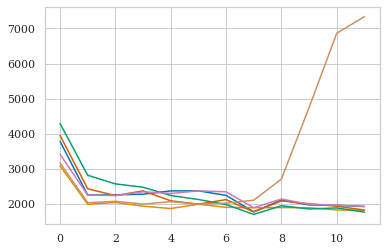

In [8]:
## Visualize data
region0 = 'Lombardia'
vals = dfmort[dfmort['region'] == region0]['total'].values.reshape(22, -1).sum(axis=0).reshape(6, -1)
plt.plot(vals.T)
plt.show()

In [9]:
## Some useful variables that will be used in the code

nages = 22   #number of age groups in the data
nyears = 6   #number of years for which we have the data
regions = np.unique(dfmort['region'].values)      #number of years for which we have the data
region0 = 'Lombardia'
      
T0 = 6


# Predict Counterfactuals with SCM & PCA

### For population

In [10]:
## For total population data

controlsyr, data, scm, pcapreds = {}, {}, {}, {}
pcavals = {}
pcafits = {}
l2020, w2020 = 0, 0

for ir, region in enumerate(regions):
    tmp = dfmort[dfmort['region'] ==  region]
    age = tmp['age_group'].values.reshape(nages, -1)
    y = tmp['total'].values.reshape(nages, -1).sum(axis=0)
    weeks = tmp['week'].values.reshape(nages, -1)[0]
    w2020 = weeks.reshape(nyears, -1)[-1]
    x = np.arange(y.size)
    xyr = len(np.array_split(x, nyears)[0])

    length = lengthperiod(weeks)
    l2020 = length.reshape(nyears, -1)[-1]
    yavg = y/length
    
    #weeks = weeks.reshape(nyears, -1) #to check that we are reshaping correctly, this should split rows to years
    if ir == 0: print('Intervention week is : ', weeks.reshape(nyears, -1)[-1][T0]) #This should be week of 15th Feb
    yy = yavg.reshape(nyears, -1)
    controls, treated = yy[:-1], yy[-1]
    means = controls.mean(axis=0)
    controlsyr[region], data[region] = controls, treated
    
    yp, _ = synth(controls, treated.reshape(1, -1), T0)
    scm[region] = yp

    pcs = []
    for i in range(4):
        yp1, pca1, pp1 = pcafit(controls, treated, T0, i)
        pcs.append([yp1, pca1])
        
    pcapreds[region] = pcs
    meancond, covcond = conditional_gaussian(means, pcs[2][1].get_covariance(), treated[:T0], T0)
    meancond = np.concatenate([treated[:T0], meancond])
    errcond = (covcond.diagonal()**0.5)
    errcond = np.concatenate([np.zeros(T0), errcond]) 
    pcavals[region] = [meancond, errcond]
    pcafits[region] = [pcs[2][0], pcs[2][1].get_covariance().diagonal()**0.5]

Intervention week is :  16/02/2020-22/02/2020


### For different age groups

In [11]:
## For different age bins
#Output error to keep tabs that they correspond to ages<40 and states with less statistics

ageregions = ['Emilia-Romagna', 'Lombardia', 'Piemonte', 'Toscana'] #['Veneto']
agegroups = ['%d-%d'%(i*10, i*10+9) for i in range(0, 10) ]
agegroups[-1] = '90 & above'


ascm, adata, acontrols, apcapreds = {}, {}, {}, {}
apcafits = {}
apcavals = {}

for ir, region in enumerate(regions):
    for age in np.arange(10):
        key = region + '%d'%age
        tmp = dfmort[dfmort['region'] ==  region]
        if age == 0:  tmp = tmp[(tmp['age_group'] <  2+age*2)]
        elif age == 10: tmp = tmp[(tmp['age_group'] >=  1+age*2)]
        else: tmp = tmp[(tmp['age_group'] >=  1+age*2) & (tmp['age_group'] <=  2+age*2)]
        nageunique = np.unique(tmp['age_group']).size
        y = tmp['total'].values.reshape(nageunique,-1).sum(axis=0)

        x = np.arange(y.size)
        xyr = len(np.array_split(x, nyears)[0])

        weeks = tmp['week'].values.reshape(nageunique,-1)[0]
        length = lengthperiod(weeks)        

        yavg = y/length        

        yy = yavg.reshape(nyears, -1)
        controls, treated = yy[:-1], yy[-1]
        means = controls.mean(axis=0)
        adata[key] = treated
        acontrols[key] = controls

        yp, _ = synth(controls, treated.reshape(1, -1), T0)
        ascm[key] = yp

        pcs = []
        for i in range(3):
            try: 
                yp1, pca1, pp1 = pcafit(controls, treated, T0, i) 
                pcs.append([yp1, pca1])
            except Exception as e: 
                print("Error : ", region, age, i, e)
                pcs.append([np.zeros_like(treated), PCA(i).fit(controls-means)])
        apcapreds[key] = pcs
        try:
            ppred, pc = apcapreds[key][2]#pca2, pcameans2
            meancond, covcond = conditional_gaussian(means, pc.get_covariance(), treated[:T0], T0)
            meancond = np.concatenate([treated[:T0], meancond])
            errcond = (covcond.diagonal()**0.5) 
            errcond = np.concatenate([np.zeros(T0), errcond]) 
            apcafits[key] = ppred, pc.get_covariance().diagonal()**0.5
            apcavals[key] = meancond, errcond
        except Exception as e:
            apcavals[key] = means, controls.std(axis=0)


# Get official covid numbers

In [12]:
   
covid = {}
lcovid2020 = {}
covidcum = {}
covidpos = {}
covidtests = {}
covidcumpos = {}
covidcumtests = {}

for region in regions:
    tmp2 = dfcovid[dfcovid['region'] == region].copy()
    deaths, cumdeath , length = [], [], []
    cumpos, cumtests = [], []
    pos, tests = [], []
    for ww in w2020:
        w0, w1 = ww.split('-')
        t0 = datetime.strptime(w0, '%d/%m/%Y')
        t1 = datetime.strptime(w1, '%d/%m/%Y')
        loc = np.array([True  if ((i - t0).days * (i - t1).days <=0) else False for i in tmp2['datetime']])
        try: 
            cumtests.append(tmp2['swabs'].values[loc][-1])
            cumpos.append(tmp2['total_cases'].values[loc][-1])
            cumdeath.append(tmp2['death'].values[loc][-1])
        except:
            cumdeath.append(0)
            cumtests.append(0)
            cumpos.append(0)
        length.append(loc.sum())
    covidcumtests[region] = np.array(cumtests) 
    covidcumpos[region] = np.array(cumpos)                                   
    covidcum[region] = np.array(cumdeath)

    covidtests[region] = np.array([0] + np.diff(cumtests).tolist()) 
    covidpos[region] = np.array([0] + np.diff(cumpos).tolist())
    covid[region] = np.array([0] + np.diff(cumdeath).tolist())
    lcovid2020[region] = np.array(length)


## Plot all regions for diagnostics

Text(0.5, 0.98, 'Cumulative number of deaths since the beginning of year')

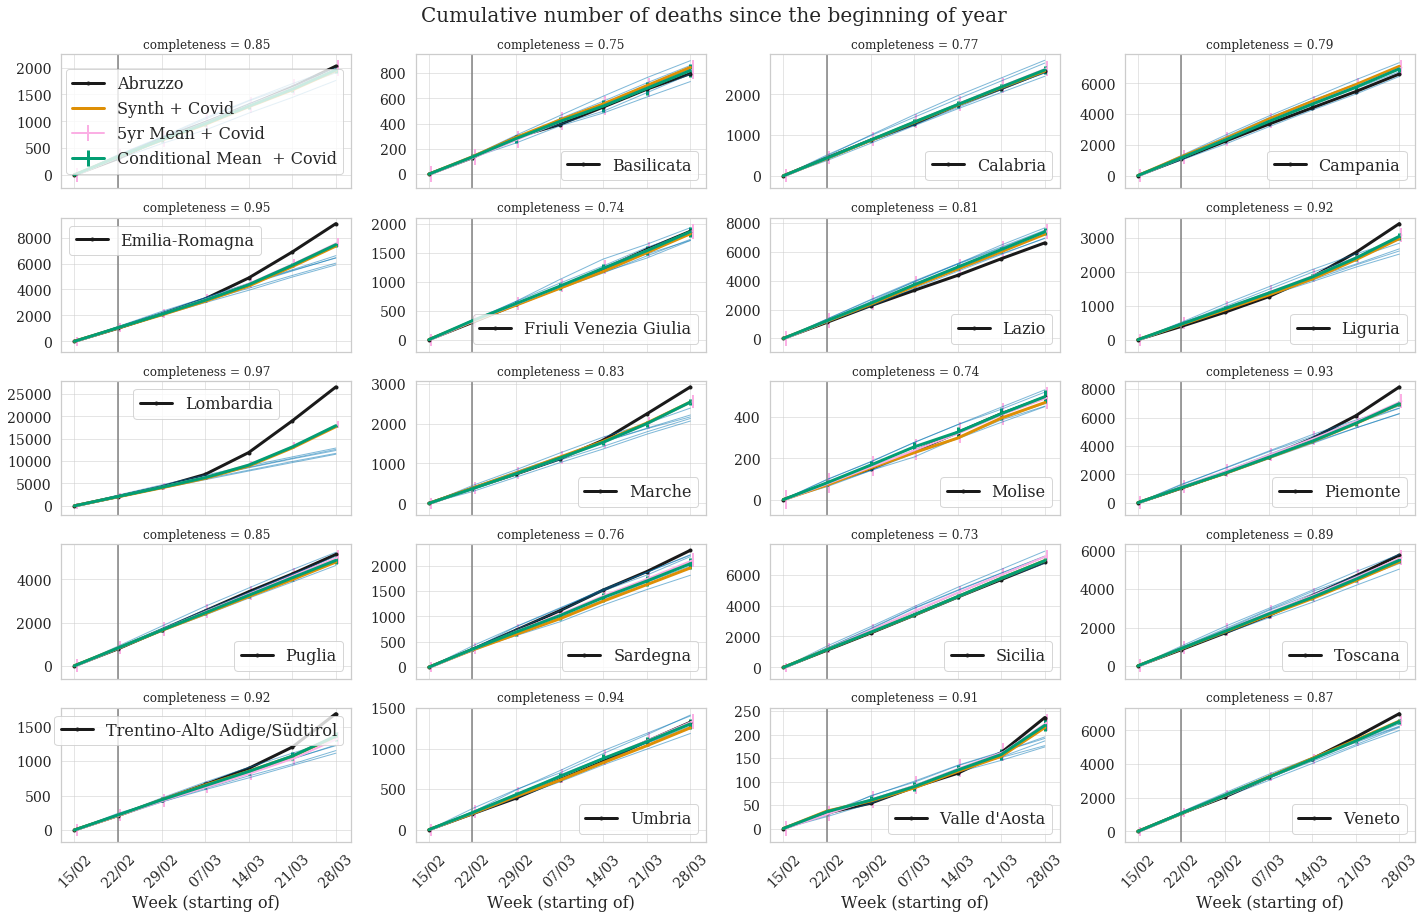

In [13]:
## plot data for all regions and select the ones to focus analysis on

xlab = [i.split('-')[1][:-5] for i in w2020]     

fig, ax = plt.subplots(5, 4, figsize=(20, 13), sharex=True)
axf = ax.flatten()
axn = 0
i0 = T0-1
normi0 = True

for ir, region in enumerate(regions):

    scale = deathscaling2[region]
    
    if 1 : #scale < 10 and ((region != "Valle d'Aosta") & (region != "Liguria")):
        lbl = region
        ddata = data[region]
        dd = np.cumsum(ddata * scale * l2020 )
        x = np.arange(dd.size)
        if normi0 : dd -= dd[i0]
        axf[axn].plot(x[i0:], dd[i0:], 'k', lw=3, label=lbl, marker='.')
        lbl = None
                

        dd = np.cumsum(controlsyr[region]*scale * l2020, axis=1).T
        if normi0 : dd -= dd[i0]
        axf[axn].plot(x[i0:], dd[i0:], 'C0', lw=1, alpha=0.5)

        if ir == 0: lbl = '5yr Mean + Covid'        
        means = controlsyr[region].mean(axis=0)
        dd = np.cumsum(means*scale * l2020)
        dd += covidcum[region]
        if normi0 : dd -= dd[i0]
        err = np.cov((controlsyr[region]).T).diagonal()**0.5 *scale * l2020
        err = np.cumsum(err**2)**0.5
        axf[axn].errorbar(x[i0:]+0.05, dd[i0:], err[i0:], color='C6', lw=2, alpha=1, label=lbl)

        if ir == 0: lbl = 'Synth + Covid'        
        dd = np.cumsum(scm[region]*scale * l2020)
        dd += covidcum[region]
        if normi0 : dd -= dd[i0]
        axf[axn].plot(x[i0:], dd[i0:], 'C1', lw=3, alpha=1, label=lbl)

        if ir == 0: lbl = 'Conditional Mean  + Covid'
        ppred, pc = pcapreds[region][2]#pca2, pcameans2
        meancond, covcond = conditional_gaussian(means, pc.get_covariance(), ddata[:T0], T0)
        meancond = np.concatenate([ddata[:T0], meancond])
        dd = np.cumsum(meancond * scale * l2020)
        dd += covidcum[region]        
        if normi0 : dd -= dd[i0]
        errcond = (covcond.diagonal()**0.5)*scale*l2020[T0:]
        errcond = np.concatenate([np.zeros(T0), np.cumsum(errcond**2)**0.5]) 
        axf[axn].errorbar(x[i0:], dd[i0:], errcond[i0:], color='C2', lw=3, alpha=1, label=lbl)

        axf[axn].axvline(x[T0], color='gray')
        axf[axn].legend(fontsize=16, ncol=1)
        axf[axn].grid(which = 'both', lw=0.5)
        axf[axn].set_title('completeness = %0.2f'%(1/scale))
        axn +=1

for axis in ax[-1,:]:
    axis.set_xticks(np.arange(data[region].size)[i0:])
    axis.set_xticklabels(xlab[i0:])
    axis.set_xlabel('Week (starting of)', fontsize=16)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Cumulative number of deaths since the beginning of year', fontsize=20)

Text(0.5, 0.98, 'Weekly number of deaths since the beginning of year')

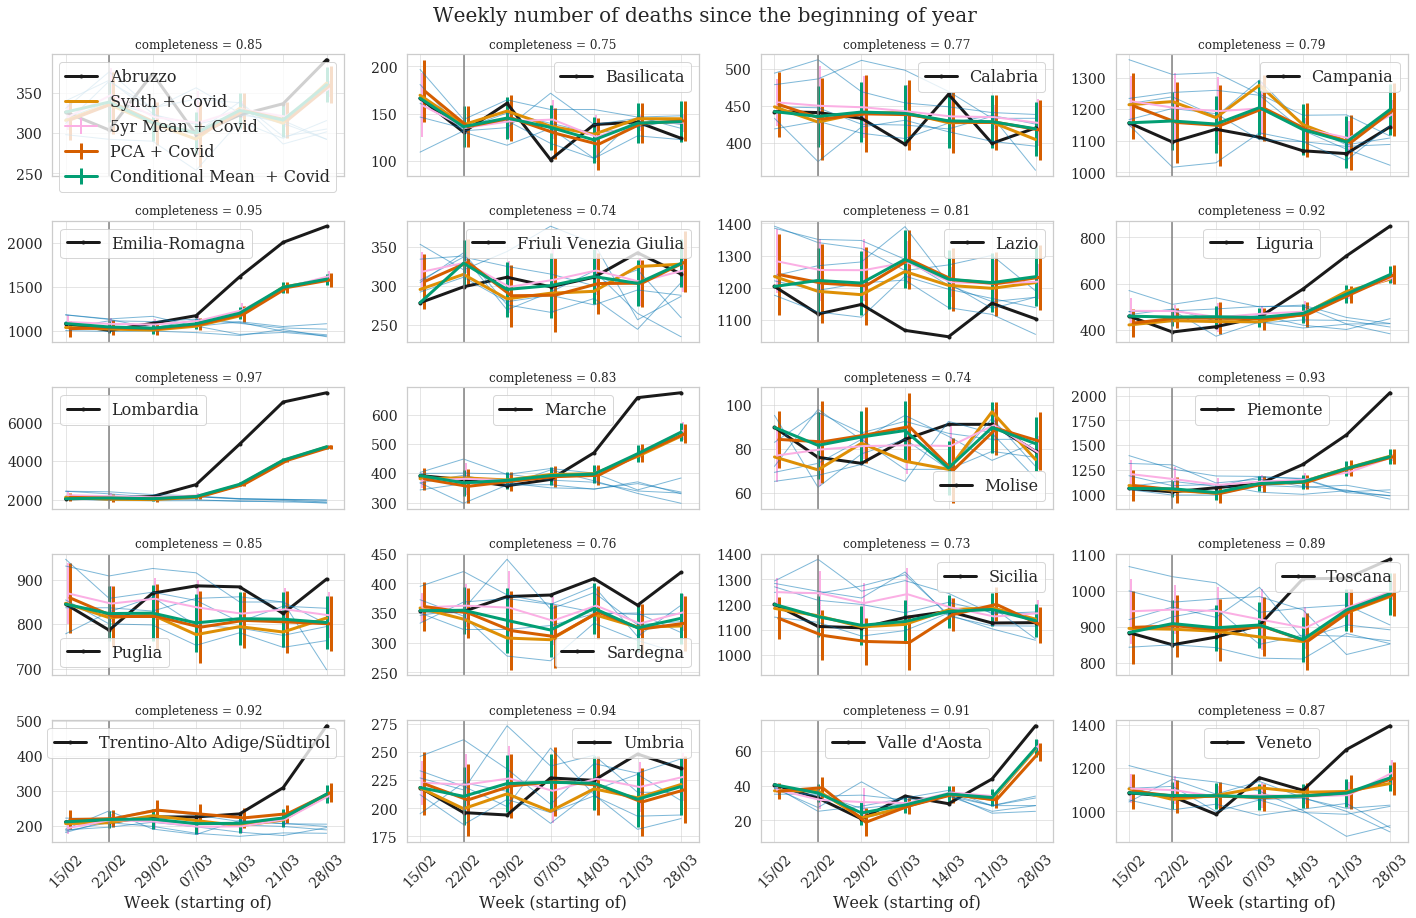

In [14]:
## plot data for all regions and select the ones to focus analysis on

xlab = [i.split('-')[1][:-5] for i in w2020]     

fig, ax = plt.subplots(5, 4, figsize=(20, 13), sharex=True)
axf = ax.flatten()
axn = 0
i0 = T0-1
normi0 = False

for ir, region in enumerate(regions):

    scale = deathscaling2[region]
    
    if 1 : #scale < 10 and ((region != "Valle d'Aosta") & (region != "Liguria")):
        lbl = region
        ddata = data[region]
        dd = (ddata * scale * l2020 )
        x = np.arange(dd.size)
        if normi0 : dd -= dd[i0]
        axf[axn].plot(x[i0:], dd[i0:], 'k', lw=3, label=lbl, marker='.')
        lbl = None
                

        dd = (controlsyr[region]*scale * l2020).T
        if normi0 : dd -= dd[i0]
        axf[axn].plot(x[i0:], dd[i0:], 'C0', lw=1, alpha=0.5)

        if ir == 0: lbl = '5yr Mean + Covid'        
        means = controlsyr[region].mean(axis=0)
        dd = (means*scale * l2020)
        dd += covid[region]
        if normi0 : dd -= dd[i0]
        err = np.cov((controlsyr[region]).T).diagonal()**0.5 *scale * l2020
#         err = np.cumsum(err**2)**0.5
        axf[axn].errorbar(x[i0:]+0.05, dd[i0:], err[i0:], color='C6', lw=2, alpha=1, label=lbl)

        if ir == 0: lbl = 'Synth + Covid'        
        dd = (scm[region]*scale * l2020)
        dd += covid[region]
        if normi0 : dd -= dd[i0]
        axf[axn].plot(x[i0:], dd[i0:], 'C1', lw=3, alpha=1, label=lbl)

        if ir == 0: lbl = 'PCA + Covid'        
        dd, dderr = pcafits[region]
        dd =  dd *scale * l2020
        dderr =  dderr *scale * l2020
        dd += covid[region]
        if normi0 : dd -= dd[i0]
        axf[axn].errorbar(x[i0:]+0.1, dd[i0:], dderr[i0:], color='C3', lw=3, alpha=1, label=lbl)

        if ir == 0: lbl = 'Conditional Mean  + Covid'
        ppred, pc = pcapreds[region][2]#pca2, pcameans2
        meancond, covcond = conditional_gaussian(means, pc.get_covariance(), ddata[:T0], T0)
        meancond = np.concatenate([ddata[:T0], meancond])
        dd = (meancond * scale * l2020)
        dd += covid[region]        
        if normi0 : dd -= dd[i0]
        errcond = (covcond.diagonal()**0.5)*scale*l2020[T0:]
        errcond = np.concatenate([np.zeros(T0), (errcond)]) 
        axf[axn].errorbar(x[i0:], dd[i0:], errcond[i0:], color='C2', lw=3, alpha=1, label=lbl)

        axf[axn].axvline(x[T0], color='gray')
        axf[axn].legend(fontsize=16, ncol=1)
        axf[axn].grid(which = 'both', lw=0.5)
        axf[axn].set_title('completeness = %0.2f'%(1/scale))
        axn +=1

for axis in ax[-1,:]:
    axis.set_xticks(np.arange(data[region].size)[i0:])
    axis.set_xticklabels(xlab[i0:])
    axis.set_xlabel('Week (starting of)', fontsize=16)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Weekly number of deaths since the beginning of year', fontsize=20)

In [15]:
mainregions = np.unique(dfmort['region'])[[4, 7, 8, 9, 11, 15, 16, 19]]
print(mainregions)

['Emilia-Romagna' 'Liguria' 'Lombardia' 'Marche' 'Piemonte' 'Toscana'
 'Trentino-Alto Adige/Südtirol' 'Veneto']


# Combine with Class 1 data to April 11

In [16]:
dfmort1 = pd.read_csv('..//data/Italy/may4_total_deaths_2015-2020//regional_historic_mortality_cl1.tsv', '\t')
# Other data sources such as total population, age distribution etc.

##Population
dfpop1 = pd.read_csv('..//data/Italy/may4_total_deaths_2015-2020/regional_population_fraction_cl1.tsv', '\t')

dfpop1['total_population'] = dfpop1['total_population'].astype(int)*1. #016
dfpop1['mortality_population'] = dfpop1['mortality_population'].astype(int)*1. #016

##Scaling factor
deathscaling1 = {}
for region in dfpop1['region'].values:
    tmp = dfpop1[dfpop1['region'] == region]
    deathscaling1[region] = (tmp['total_population']/tmp['mortality_population']).values[0]


controlsyr1, data1, scm1, pcapreds1 = {}, {}, {}, {}
pcavals1, pcafits1 = {}, {}
datascaling1 = {}

ascm1, adata1, acontrols1, apcapreds1 = {}, {}, {}, {}
apcavals1, apcafits1 = {}, {}

extrap = {}
for ir, region in enumerate(regions):
    
    scale = deathscaling2[region]    
    if region in regions : 

            ####Extrap here            
            tmp = dfmort1[dfmort1['region'] ==  region]
            scale1 = deathscaling1[region]
            age = tmp['age_group'].values.reshape(nages, -1)
            y = tmp['total'].values.reshape(nages, -1).sum(axis=0)
            weeks = tmp['week'].values.reshape(nages, -1)[0]
            w20201 = weeks.reshape(nyears, -1)[-1]
            x = np.arange(y.size)
            xyr = len(np.array_split(x, nyears)[0])

            length1 = lengthperiod(weeks)
            l20201 = length1.reshape(nyears, -1)[-1]
            yavg = y/length1

            if ir == 0: print('Intervention week is : ', weeks.reshape(nyears, -1)[-1][T0]) #This should be week of 15th Feb
            yy = yavg.reshape(nyears, -1)
            controls, treated = yy[:-1], yy[-1]
            means = controls.mean(axis=0)
            yp, _ = synth(controls, treated.reshape(1, -1), T0)       
            pcs = []
            for i in range(3):
                try: 
                    yp1, pca1, pp1 = pcafit(controls, treated, T0, i) 
                    pcs.append([yp1, pca1])
                except Exception as e: 
                    print("Error : ", region, age, i, e)
                    pcs.append([np.zeros_like(treated), PCA(i).fit(controls-means)])
            
            pc = pcs[2][1]
            meancond1, covcond = conditional_gaussian(means, pc.get_covariance(), treated[:T0], T0)
            meancond1 = np.concatenate([treated[:T0], meancond1])
            errcond1 = (covcond.diagonal()**0.5)#*scale*l20201[T0:]
            errcond1 = np.concatenate([np.zeros(T0), errcond1]) 
            
            controlsyr1[region], data1[region] = controls, treated
            pcapreds1[region] = pcs
            pcavals1[region] = [meancond1, errcond1]
            pcafits1[region] = [pcs[2][0], pc.get_covariance().diagonal()**0.5]
            scm1[region] = yp

            scalemean = (data[region]*l2020*deathscaling2[region]/treated[:-2])[T0:].mean()
#             scalemean = (data[region]*l2020*deathscaling2[region]/treated[:-2])[-1]
            datascaling1[region] = scalemean

            
            for age in np.arange(10):
                key = region + '%d'%age
                tmp = dfmort1[dfmort1['region'] ==  region]
                if age == 0:  tmp = tmp[(tmp['age_group'] <  2+age*2)]
                elif age == 10: tmp = tmp[(tmp['age_group'] >=  1+age*2)]
                else: tmp = tmp[(tmp['age_group'] >=  1+age*2) & (tmp['age_group'] <=  2+age*2)]
                nageunique = np.unique(tmp['age_group']).size
                y = tmp['total'].values.reshape(nageunique,-1).sum(axis=0)

                x = np.arange(y.size)
                xyr = len(np.array_split(x, nyears)[0])

                weeks = tmp['week'].values.reshape(nageunique,-1)[0]
                length = lengthperiod(weeks)        

                yavg = y/length        

                yy = yavg.reshape(nyears, -1)
                controls, treated = yy[:-1], yy[-1]
                acontrols1[key], adata1[key] = controls, treated
                means = controls.mean(axis=0)

                yp, _ = synth(controls, treated.reshape(1, -1), T0)
                ascm1[key] = yp

                pcs = []
                for i in range(3):
                    try: 
                        yp1, pca1, pp1 = pcafit(controls, treated, T0, i) 
                        pcs.append([yp1, pca1])
                    except Exception as e: 
                        print("Error : ", region, age, i, e)
                        pcs.append([np.zeros_like(treated), PCA(i).fit(controls-means)])
                        
                apcapreds1[key] = pcs

                try:
                    ppred, pc = apcapreds1[key][2]#pca2, pcameans2
                    meancond, covcond = conditional_gaussian(means, pc.get_covariance(), treated[:T0], T0)
                    meancond = np.concatenate([treated[:T0], meancond])
                    errcond = (covcond.diagonal()**0.5) 
                    errcond = np.concatenate([np.zeros(T0), errcond]) 
                    apcavals1[key] = meancond, errcond
                    apcafits1[key] = [ppred, pc.get_covariance().diagonal()**0.5]
                except Exception as e:
                    print(e, " for key = ", key)
                    apcavals1[key] = [means, controls.std(axis=0)]
                    apcafits1[key] = [means, controls.std(axis=0)]



Intervention week is :  16/02/2020-22/02/2020
Error :  Molise 1 1 array must not contain infs or NaNs
Error :  Molise 1 2 array must not contain infs or NaNs
Singular matrix  for key =  Molise1


In [17]:
 
covid1 = {}
lcovid20201 = {}
covidcum1 = {}
covidpos1 = {}
covidtests1 = {}
covidcumpos1 = {}
covidcumtests1 = {}

for region in regions:
    tmp2 = dfcovid[dfcovid['region'] == region].copy()
    deaths, cumdeath , length = [], [], []
    cumpos, cumtests = [], []
    pos, tests = [], []
    for ww in w20201:
        w0, w1 = ww.split('-')
        t0 = datetime.strptime(w0, '%d/%m/%Y')
        t1 = datetime.strptime(w1, '%d/%m/%Y')
        loc = np.array([True  if ((i - t0).days * (i - t1).days <=0) else False for i in tmp2['datetime']])
        try: 
            cumtests.append(tmp2['swabs'].values[loc][-1])
            cumpos.append(tmp2['total_cases'].values[loc][-1])
            cumdeath.append(tmp2['death'].values[loc][-1])
        except:
            cumdeath.append(0)
            cumtests.append(0)
            cumpos.append(0)
        length.append(loc.sum())
    covidcumtests1[region] = np.array(cumtests) 
    covidcumpos1[region] = np.array(cumpos)                                   
    covidcum1[region] = np.array(cumdeath)

    covidtests1[region] = np.array([0] + np.diff(cumtests).tolist()) 
    covidpos1[region] = np.array([0] + np.diff(cumpos).tolist())
    covid1[region] = np.array([0] + np.diff(cumdeath).tolist())
    lcovid20201[region] = np.array(length)


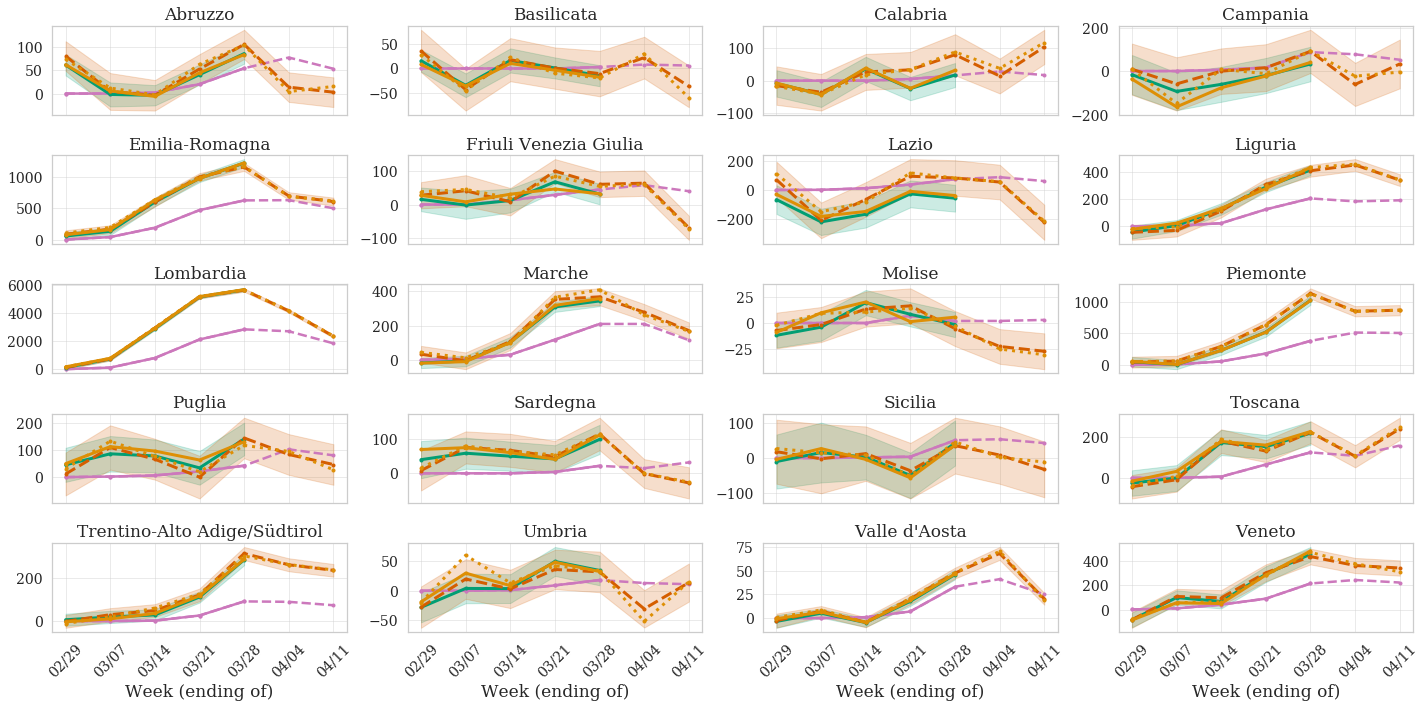

In [18]:
###  plot weekly residuals for population


Td = 5 #number of data points we have
isplit = [6] + [6+i*7 for i in range(1, 6)]
xlab = [i[-1] for i in np.split(dfcovid[dfcovid['region'] == 'Lombardia']['date'].values, isplit)]
xlab = [i.split('-')[1]+'/'+i.split('-')[2].split('T')[0] for i in xlab]
xlab[-1] = '04/11'

fig, ax = plt.subplots(5, 4, figsize=(20, 10), sharex=True)
axf = ax.flatten()
axn = 0 
i0 = T0+1
normi0 = False

for ir, region in enumerate(regions):
# for ir, region in enumerate(mainregions):
#     if region == 'Puglia' : continue
    scale = deathscaling2[region]
    key = region
    xplot = np.arange(covid[key].size)
    xplot1 = np.arange(covid1[key].size)


    lbl = None
    if axn == 0: lbl = "Covid-19 Official"
    yy = covid[key]
    axf[axn].plot(xplot[i0:], yy[i0:], marker='.', lw=2.5, color='C4', label=lbl)
    yy1 = covid1[key]
    axf[axn].plot(xplot1[i0:], yy1[i0:], ls="--", marker='.', lw=2.5, color='C4', label=lbl)
    #

    lbl = None
    if axn == 1: lbl = "Excess over SCM"
    dd = (data[key] - scm[key])*l2020*scale
    axf[axn].errorbar(xplot[i0:], dd[i0:], 
                      color='C1', ls = "-", marker='.', lw=3, label=lbl)

#     dd = (data1[key] - scm1[key])*l20201*deathscaling1[region]
#     axf[axn].errorbar(xplot1[i0:], dd[i0:], 
#                       color='C1', ls = "--", marker='.', lw=3, label=lbl)
    
    dd = (data1[key] - scm1[key])*datascaling1[region]
    axf[axn].errorbar(xplot1[i0:], dd[i0:], 
                      color='C1', ls = ":", marker='.', lw=3, label=lbl)
    
    lbl = None
    if axn == 1: lbl = "Excess over CGP"
    meancond, errcond = pcavals[region]
    dd = (data[key] - meancond)*l2020*scale
    err = errcond *l2020*scale
    axf[axn].plot(xplot[i0:], dd[i0:],
                      color='C2', ls = "-", marker='.', lw=3, label=lbl)
    axf[axn].fill_between(xplot[i0:], (dd-err)[i0:], (dd+err)[i0:],
                      color='C2', alpha=0.2)

    meancond, errcond = pcavals1[region]
    dd = (data1[key] - meancond)*datascaling1[region]
    err = errcond *datascaling1[region]
    axf[axn].plot(xplot1[i0:], dd[i0:],
                      color='C3', ls = "--", marker='.', lw=3, label=lbl)
    axf[axn].fill_between(xplot1[i0:], (dd-err)[i0:], (dd+err)[i0:],
                      color='C3', alpha=0.2)
#         lbl = None
#         if axn == 2: lbl = "Excess over CGP"
#         dd = extrapcgpmean[key]

#         axf[axn].errorbar(xplot[:Td], dd[:Td],  
#                           color='C2', ls = "-", marker='.', lw=3, label=lbl)
#         axf[axn].errorbar(xplot[Td-1:], dd[Td-1:],  
#                           color='C2', ls = "--", marker='.', lw=3)
#         axf[axn].fill_between(xplot, 
#                               dd - extrapcgpmeaner[key], 
#                               dd + extrapcgpmeaner[key], 
#                               color='C2', alpha=0.3)
        

#     if axn in [0, 1, 2]: axf[axn].legend(fontsize=16, ncol=1, loc=0)
    axf[axn].grid(which = 'both', lw=0.5, alpha=0.8)
    axf[axn].set_title(region, fontsize=17)
    axn +=1
    

for axis in ax[-1,:]:
    axis.set_xticks(np.arange(covid1[key].size)[i0:])
    axis.set_xticklabels(xlab)
    axis.set_xlabel('Week (ending of)', fontsize=17)
# for axis in ax[:,0]:
#     axis.set_ylabel('Weekly excess mortality', fontsize=14)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    
plt.tight_layout()
plt.show()

# Extrapolate to May 9

In [19]:
# ### Uncomment for debugging

# Td = 5 #number of data points we have
# nextrap = 10
# isplit = [6] + [6+i*7 for i in range(1, nextrap)]# xlab[-1] = '04/11'
# xlab = [i[6]  if i.size >=7 else i[-1] for i in np.split(dfcovid[dfcovid['region'] == 'Lombardia']['date'].values, isplit)]
# xlab = [i.split('-')[1]+'/'+i.split('-')[2].split('T')[0] for i in xlab]
# print(xlab)


# region = 'Lombardia'
# cumvals = dfcovid[dfcovid['region'] == region]['death'].values
# cumvals = np.split(cumvals, isplit)
# cumvalsw = np.array([i[6]  if i.size >=7 else i[-1] for i in cumvals ])
# print(cumvalsw)
# if cumvals[-1].size < 7:
#     v0, v1 = cumvals[-1][0] + (cumvals[-1][-1] - cumvals[-1][0])*7/cumvals[-1].size, cumvals[-2][-1] + (cumvals[-1][-1] - cumvals[-2][-1])*7/cumvals[-1].size
# #     print(v0, v1)
#     cumvalsw[-1] = min(v0, v1)
# valsw = np.array([cumvalsw[0]] + np.diff(cumvalsw).tolist())
# print(valsw)

# scmpred =  scm[region]*l2020*deathscaling2[region]
# ddata = data[region]*l2020*deathscaling2[region]
# excessscm = (ddata - scmpred)
# excessscm[-Td:].size, valsw.size

# exsize = valsw.size - excessscm[-Td:].size
# print(exsize)
# mm = (valsw[-1] - excessscm[-1]) / exsize
# print(excessscm[-1], [mm*i + excessscm[-1] for i in range(1, exsize+1)], valsw[-1])
# # plt.plot(excessscm)
# plt.plot(valsw, 'o')
# plt.gca().set_xticks(np.arange(valsw.size))
# plt.gca().set_xticklabels(xlab[:])
# plt.gca().tick_params(axis='x', rotation=45)
# plt.show()
# # plt.plot(np.diff(np.concatenate(cumvals)))

### with official COVID-19 data

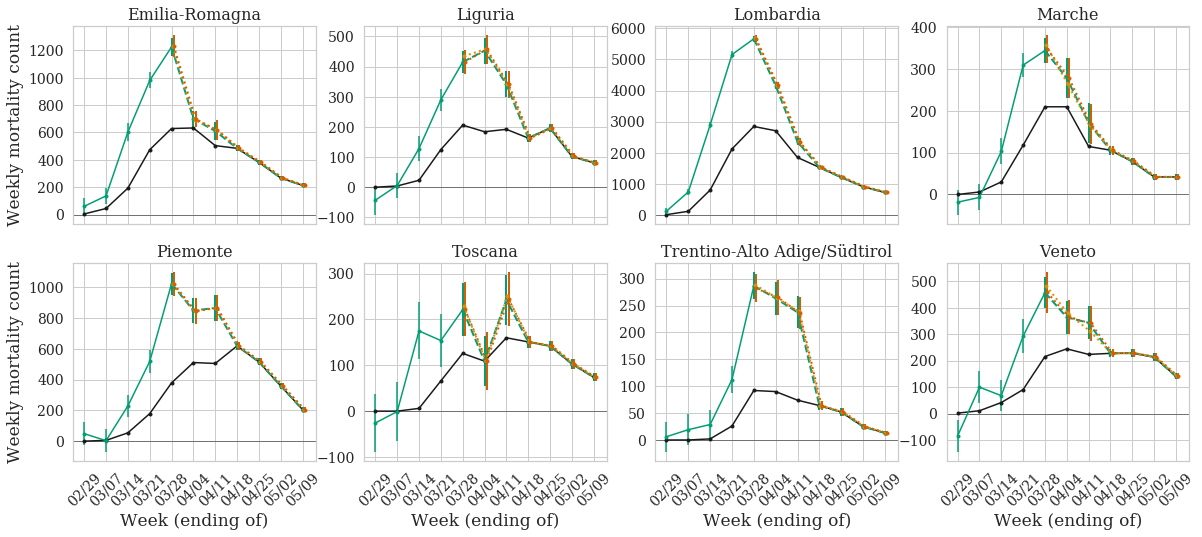

In [20]:
Td = 5 #number of data points we have
Td2 = Td + 2
nextrap = 10
    

dateextrap = "2020-05-02"
isplit = [6] + [6+i*7 for i in range(1, nextrap)]
xlab = [i[6]  if i.size >=7 else i[-1] for i in np.split(dfcovid[dfcovid['region'] == 'Lombardia']['date'].values, isplit)]
xlab = [i.split('-')[1]+'/'+i.split('-')[2].split('T')[0] for i in xlab]
# xlab[-1] = '%s/%s'%(dateextrap.split('-')[1], dateextrap.split('-')[2])

fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharex=True)
axf = ax.flatten()
axn = 0
i0 = 0

extrapcovid = {}
extrappcfits, extrappcfitser = {}, {}
extrapcgpmean, extrapcgpmeaner = {}, {}
extrapscmmean = {}
extrappcfits2, extrapscmmean2, extrapcgpmean2 = {}, {}, {}

extrap = {}
for ir, region in enumerate(regions):
    
    scale = deathscaling2[region]    
    if region in regions : 
        try:
#             print(region)
            cumvals = dfcovid[dfcovid['region'] == region]['death'].values
            cumvals = np.split(cumvals, isplit)
            cumvalsw = np.array([i[6]  if i.size >=7 else i[-1] for i in cumvals ])
            cumvalsw[-1] = cumvals[-1][0] + (cumvals[-1][-1] - cumvals[-1][0])*7/cumvals[-1].size
            if cumvals[-1].size < 7:
                cumvalsw[-1] = cumvals[-2][-1] + (cumvals[-1][-1] - cumvals[-2][-1])*7/cumvals[-1].size
            valsw = np.array([cumvalsw[0]] + np.diff(cumvalsw).tolist())
            extrapcovid[region] = valsw

            means = controlsyr[region].mean(axis=0)
            ddata = data[region].copy()
            meancond, errcond = pcavals[region]
            meancond = meancond  *l2020*scale
            errcond = errcond * l2020*scale
            pcmean, pcerr = pcafits[region]
            pcmean = pcmean  *l2020*scale
            pcerr = pcerr * l2020*scale

            scmpred =  scm[region]*l2020*deathscaling2[region]

            ddata = ddata*l2020*scale
            excess = (ddata - meancond) 
            excesspca = (ddata - pcmean) 
            excessscm = (ddata - scmpred)

            #Extraphere
            toapp = ((data1[region] - scm1[region])*datascaling1[region]).tolist()[-2:]
            extrapscmmean[region] = np.concatenate([excessscm[-Td:], toapp, valsw[Td2:]])
#             extrapscmmean2[region] = extrapscmmean[region].copy()
#             extrapscmmean2[region][extrapscmmean[region] < valsw] = valsw[extrapscmmean[region] < valsw]
            extrapscmmean[region][extrapscmmean[region] < valsw] = valsw[extrapscmmean[region] < valsw]

            meancond1, errcond1 = pcavals1[region]
            toapp = ((data1[region] - meancond1)*datascaling1[region]).tolist()[-2:]
            extrapcgpmean[region] = np.concatenate([excess[-Td:], toapp, valsw[Td2:]])
            toapp = (errcond1*datascaling1[region]).tolist()[-2:]
            extrapcgpmeaner[region] = np.concatenate([errcond[-Td:], toapp, valsw[Td2:]**0.5])
#             extrapcgpmean2[region] = extrapcgpmean[region].copy()
#             extrapcgpmean2[region][extrapcgpmean[region] < valsw] = valsw[extrapcgpmean[region] < valsw]
            extrapcgpmean[region][extrapcgpmean[region] < valsw] = valsw[extrapcgpmean[region] < valsw]
            extrapcgpmeaner[region][extrapcgpmean[region] < valsw] = valsw[extrapcgpmean[region] < valsw]**0.5
            
            pcmean1, pcerr1 = pcafits1[region]
            toapp = ((data1[region] - pcmean1)*datascaling1[region]).tolist()[-2:]
            extrappcfits[region] = np.concatenate([excesspca[-Td:], toapp, valsw[Td2:]])
            toapp = (pcerr1*datascaling1[region]).tolist()[-2:]
            extrappcfitser[region] = np.concatenate([pcerr[-Td:], toapp, valsw[Td2:]**0.5])
#             extrappcfits2[region] = extrappcfits[region].copy()
#             extrappcfits2[region][extrappcfits[region] < valsw] = valsw[extrappcfits[region] < valsw]
            extrappcfits[region][extrappcfits[region] < valsw] = valsw[extrappcfits[region] < valsw]
            extrappcfitser[region][extrappcfits[region] < valsw] = valsw[extrappcfits[region] < valsw]**0.5
        

        except Exception as e:
            print("Exception : ",e)
#
        ##Make fig
        if region in mainregions:
            xplot = np.arange(valsw.size)
            axf[axn].errorbar(xplot, valsw, marker='.', color='k')
            axf[axn].errorbar(xplot[:Td], excess[-Td:], errcond[-Td:], marker='.', color='C2')
#             axf[axn].errorbar(xplot[:Td+2], excessscm[-Td-2:],  marker='.', color='C1')
#             axf[axn].errorbar(xplot[:Td+2]+0.1, excesspca[-Td:], pcerr[-Td:], marker='.', color='C3')
#             lbl = None

            axf[axn].errorbar(xplot[Td-1:]+0., extrapcgpmean[region][Td-1:], extrapcgpmeaner[region][Td-1:],
                              ls='--', marker='.', color='C2', lw=2)
            axf[axn].errorbar(xplot[Td-1:]+0.05, extrapscmmean[region][Td-1:], ls=':', 
                              marker='.', color='C1', lw=2)
            axf[axn].errorbar(xplot[Td-1:]+0.1, extrappcfits[region][Td-1:], extrappcfitser[region][Td-1:], ls=':', 
                              marker='.', color='C3', lw=2)

#             axf[axn].grid(which='both')
            axf[axn].set_title(region, fontsize=16)
            axn += 1
    

for axis in ax[-1,:]:
    axis.set_xticks(np.arange(valsw.size))
    axis.set_xticklabels(xlab[i0:])
    axis.set_xlabel('Week (ending of)', fontsize=17)
for axis in ax[:,0]:
    axis.set_ylabel('Weekly mortality count', fontsize=17)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.axhline(0, color='k', lw=0.5)
    #plt.legend(fontsize=14)


## For total population data


### Assuming constant missed fraction

In [21]:

extrapscmmeanflat, extrapcgpmeanflat, extrapcgpmeanflater = {}, {}, {}
for rr in regions:
    extrapscmmeanflat[rr] = extrapscmmean[rr].copy()
    ratio = extrapscmmean[rr][Td2-1]/extrapcovid[rr][Td2-1]
    extrapscmmeanflat[rr][Td2:] = extrapscmmeanflat[rr][Td2:] * ratio
    
    extrapcgpmeanflat[rr] = extrapcgpmean[rr].copy()
    ratio = extrapcgpmeanflat[rr][Td2-1]/extrapcovid[rr][Td2-1]
    extrapcgpmeanflat[rr][Td2:] = extrapcgpmeanflat[rr][Td2:] * ratio
    extrapcgpmeanflater[rr] = extrapcgpmeaner[rr].copy()
    extrapcgpmeanflater[rr][Td2:] = extrapcgpmeanflater[rr][Td2:]*ratio**0.5
    


In [22]:
print("Total number of deaths by SCM method under 2 extrpolations")
sum([extrapscmmean[rr].sum() for rr in regions]), sum([extrapscmmeanflat[rr].sum() for rr in regions])

Total number of deaths by SCM method under 2 extrpolations


(49425.84998243212, 53806.86402480508)

In [23]:
print("Total number of deaths by CGP method under 2 extrpolations")
sum([extrapcgpmean[rr].sum() for rr in regions]), sum([extrapcgpmeanflat[rr].sum() for rr in regions])

Total number of deaths by CGP method under 2 extrpolations


(48859.30951315059, 53244.17202669948)

### Extrapolate for age groups with COVID data

No handles with labels found to put in legend.


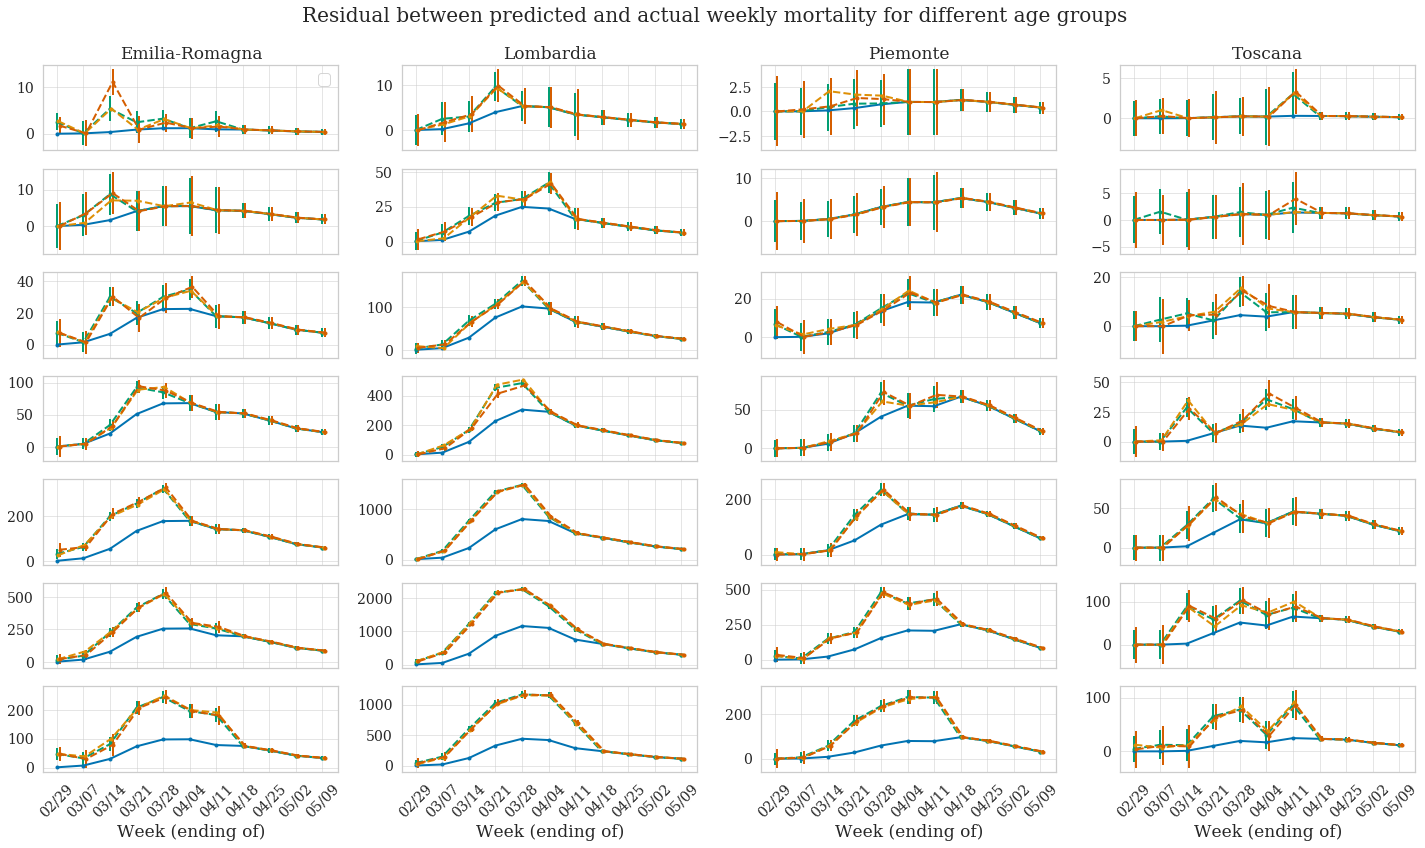

In [24]:
# Do for differet age groups

# Td = 5 #number of data points we have
# isplit = [6] + [6+i*7 for i in range(1, 6)]
# xlab = [i[-1] for i in np.split(dfcovid[dfcovid['region'] == 'Lombardia']['date'].values, isplit)]
# xlab = [i.split('-')[1]+'/'+i.split('-')[2].split('T')[0] for i in xlab]
# xlab[-1] = '04/11'


aextrapcovid = {}
aextrapcgpmean, aextrapcgpmeaner, aextrapscmmean = {}, {}, {}
aextrappcfits, aextrappcfitser = {}, {}

for ir, region in enumerate(regions):
    
    if  region!= 'Bergamo': #scale < 10 and ((region != "Valle d'Aosta") & (region != "Liguria")& (region != "Umbria")):
        scale = deathscaling2[region]    
        for age in range( 10):
            key = region + '%d'%age
            cumvals = dfcovid[dfcovid['region'] == region]['death'].values *agecvd[age]
            cumvals = np.split(cumvals, isplit)
            cumvalsw = np.array([i[6]  if i.size >=7 else i[-1] for i in cumvals ])
            cumvalsw[-1] = cumvals[-1][0] + (cumvals[-1][-1] - cumvals[-1][0])*7/cumvals[-1].size
            if cumvals[-1].size < 7:
            #     cumvalsw[-1] = cumvals[-1][0] + (cumvals[-1][-1] - cumvals[-1][0])*7/cumvals[-1].size
                cumvalsw[-1] = cumvals[-2][-1] + (cumvals[-1][-1] - cumvals[-2][-1])*7/cumvals[-1].size
            valsw = np.array([cumvalsw[0]] + np.diff(cumvalsw).tolist())
            aextrapcovid[key] = valsw

            means = acontrols[key].mean(axis=0)
            ddata = adata[key].copy()

            meancond, errcond = apcavals[key]
            meancond = meancond.copy()*l2020*scale
            errcond = errcond.copy()*l2020*scale
            scmpred = ascm[key]*l2020*scale
            pcmean, pcerr = apcafits[key]
            pcmean = pcmean  *l2020*scale
            pcerr = pcerr * l2020*scale

            ddata = ddata *l2020*scale

            excess = (ddata - meancond) 
            excessscm = (ddata - scmpred) 
            excesspca = (ddata - pcmean) 

            #Extraphere
            toapp = ((adata1[key] - ascm1[key])*datascaling1[region]).tolist()[-2:]
            aextrapscmmean[key] = np.concatenate([excessscm[-Td:], toapp, valsw[Td2:]])            
            #
            aextrapscmmean[key][aextrapscmmean[key] < valsw] = valsw[aextrapscmmean[key] < valsw]

            meancond1, errcond1 = apcavals1[key]
            toapp = ((adata1[key] - meancond1)*datascaling1[region]).tolist()[-2:]
            aextrapcgpmean[key] = np.concatenate([excess[-Td:], toapp, valsw[Td2:]])
            toapp = (errcond1*datascaling1[region]).tolist()[-2:]
            aextrapcgpmeaner[key] = np.concatenate([errcond[-Td:], toapp, valsw[Td2:]**0.5])           
            #
            aextrapcgpmean[key][aextrapcgpmean[key] < valsw] = valsw[aextrapcgpmean[key] < valsw]
            aextrapcgpmeaner[key][aextrapcgpmean[key] < valsw] = valsw[aextrapcgpmean[key] < valsw]**0.5
            
            pcmean1, pcerr1 = apcafits1[key]
            toapp = ((adata1[key] - pcmean1)*datascaling1[region]).tolist()[-2:]
            aextrappcfits[key] = np.concatenate([excesspca[-Td:], toapp, valsw[Td2:]])            
            toapp = (pcerr1*datascaling1[region]).tolist()[-2:]
            aextrappcfitser[key] = np.concatenate([pcerr[-Td:], toapp, valsw[Td2:]**0.5])            
            #
            aextrappcfits[key][aextrappcfits[key] < valsw] = valsw[aextrappcfits[key] < valsw]
            aextrappcfitser[key][aextrappcfits[key] < valsw] = valsw[aextrappcfits[key] < valsw]**0.5

            
            
                
fig, ax = plt.subplots(7, 4, figsize=(20, 12), sharex=True)
axf = ax.flatten()
axn = 0 
i0 = T0+1
normi0 = False

for ia, age in enumerate(range(3, 10)):
    for ir, region in enumerate(ageregions):
        key = region + '%d'%age
        xplot = np.arange(aextrapcovid[key].size)
        axf[axn].plot(xplot, aextrapcovid[key], marker='.', lw=2, color='C0')
        #
        axf[axn].errorbar(xplot[:]+0.0, aextrapcgpmean[key][:], aextrapcgpmeaner[key][:], 
                          color='C2', ls = "--", marker='.', lw=2)
        axf[axn].errorbar(xplot[:]+0.05, aextrapscmmean[key][:],
                          color='C1', ls = "--", marker='.', lw=2)
        axf[axn].errorbar(xplot[:]+0.1, aextrappcfits[key][:], aextrappcfitser[key][:], 
                          color='C3', ls = "--", marker='.', lw=2)

        if axn == 0: axf[axn].legend(fontsize=16, ncol=1, loc=0)
        axf[axn].grid(which = 'both', lw=0.5)
        if axn < 4:axf[axn].set_title(region, fontsize=17)
        axn +=1
    

for axis in ax[-1,:]:
    axis.set_xticks(xplot)
    axis.set_xticklabels(xlab)
    axis.set_xlabel('Week (ending of)', fontsize=17)
# for axis in ax[:,0]:
#     axis.set_ylabel('Total mortality count', fontsize=17)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
#     plt.axhline(0, color='k', lw=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Residual between predicted and actual weekly mortality for different age groups', fontsize=20)
plt.show()

# Repeat the analysis for Bergamo with provice data instead of regional

### Covid data for Bergamo from Eco-diBergamo

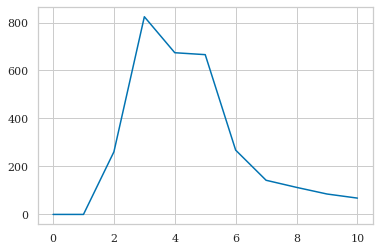

In [25]:
val411 = 2693
val418 = (2754-2693)/3*7 + val411
val425 = extrapcovid['Lombardia'][Td2+1]/extrapcovid['Lombardia'][Td2]*(val418-val411) + val418
val502 = extrapcovid['Lombardia'][Td2+2]/extrapcovid['Lombardia'][Td2+1]*(val425-val418) + val425
val509 = extrapcovid['Lombardia'][Td2+3]/extrapcovid['Lombardia'][Td2+2]*(val502-val425) + val502
# if nextrap == 6:  bergamodata = np.array([0, 0, 0, 261, 1085, 1759, 2425, 2693])  ##Cumulative data read manually for Bergamo
bergamodata = np.array([0, 0, 0, 261, 1085, 1759, 2425, 2693, val418, val425, val502, val509])  ##Cumulative data read manually for Bergamo
bergamoagedata = np.array([0, 0, 0, 3, 25, 98, 361, 917, 881, 140]) ## age distribution read manually 

## Weekly numbers copied for different age groups below, should add upto numbers in bergamoagedata
# 22+17+27+24+29+38+44+47+44+69
# 66+88+88+90+79+101+95+99+87+124
# 114+116+106+84+105+85+83+76+66+46
# 31+30+31+15+12+8+6+1+5+1
# vals = dfcovid[dfcovid['region'] == 'Lombardia'][-1:].values
# vals[0][4] = "Bergamo"
# dfcovid = dfcovid.append(pd.DataFrame(vals.reshape(1, -1), columns=dfcovid.columns))

plt.plot(np.diff(bergamodata))

In [26]:
#
dfread = pd.read_csv('..//data/Italy/may4_total_deaths_2015-2020/comuni_giornaliero.csv', encoding='latin1')
df = dfread[dfread['NOME_PROVINCIA'] == 'Bergamo']
del dfread

df = df.rename(columns={'NOME_COMUNE':'town', 'NOME_REGIONE':'region', 'NOME_PROVINCIA':'province', 'CL_ETA':'ages', 'GE':'dates'})
df = df[df['TIPO_COMUNE'] <= 2]
dfcut = df[df['dates'] <=328]


In [27]:

## Get the data
mainregionsb = np.append(mainregions, 'Bergamo')

#
dfread = pd.read_csv('../data/Italy/may4_total_deaths_2015-2020/comuni_giornaliero.csv', encoding='latin1')
df = dfread[dfread['NOME_PROVINCIA'] == 'Bergamo']
del dfread

df = df.rename(columns={'NOME_COMUNE':'town', 'NOME_REGIONE':'region', 'NOME_PROVINCIA':'province', 'CL_ETA':'ages', 'GE':'dates'})
df = df[df['TIPO_COMUNE'] <= 2]
dfcut = df[df['dates'] <=328]

# df = df[df['dates'] <=328]
# dfwaste = df[(df['TOTALE_20'] == 9999)]
# dfcut = df[~(df['TOTALE_20'] == 9999).values]

weeks = ['01/01/2015-11/01/2015', '12/01/2015-18/01/2015',
             '19/01/2015-25/01/2015', '26/01/2015-01/02/2015',
             '02/02/2015-08/02/2015', '09/02/2015-15/02/2015',
            '16/02/2015-22/02/2015', '23/02/2015-29/02/2015',
             '01/03/2015-07/03/2015', '08/03/2015-14/03/2015',
             '15/03/2015-21/03/2015', '22/03/2015-28/03/2015']
colsave = ['week', 'region', 'age_group', 'male', 'female', 'total']
ages = np.arange(22)
years = [15, 16, 17, 18, 19, 20]
dates = [[101, 111], [112, 118], [119, 125], [126, 201], [202, 208], [209, 215], [216, 222], [223, 229],
    [301, 307], [308, 314], [315, 321], [322, 328]]

for year in years:
    cols = ['M_%d'%year, 'F_%d'%year, 'T_%d'%year]
    for cc in cols:
        dfcut[cc] = dfcut[cc].astype(int)

tmp = dfcut
dfmortb = pd.DataFrame(columns=colsave, dtype=None)
for ia, age in enumerate(ages):
    tmpa = tmp[(tmp['ages'] == age)]
    for year in years:
        cols = ['M_%d'%year, 'F_%d'%year, 'T_%d'%year]
        weeklabel = [i[:8] + '%d'%year + i[10:-2]+ '%d'%year for i in weeks]

        for iw, week in enumerate(weeks):
            tmpw = tmpa[(tmpa['dates'] >= dates[iw][0]) & (tmpa['dates'] <= dates[iw][1])]
            deaths = tmpw[cols].sum().astype(float).tolist()
            entry = np.array([weeklabel[iw], 'Bergamo', ia] + deaths).reshape(1, -1)
            dfmortb = dfmortb.append(pd.DataFrame(entry, columns=colsave), ignore_index=True)

dfmortb['age_group'] = dfmortb['age_group'].astype(int)
dfmortb['male'] = dfmortb['male'].astype(float)
dfmortb['female'] = dfmortb['female'].astype(float)
dfmortb['total'] = dfmortb['total'].astype(float)



#
dfpopb = pd.read_excel('../data/Italy/Elenco-comuni-italiani.xls')
dfpopb = dfpopb[dfpopb['Codice Regione'] == 3]
dfpopb = dfpopb[dfpopb['Codice Provincia (Storico)(1)'] == 16]
popdictb = dict(dfpopb[['Denominazione in italiano', 'Popolazione legale 2011 (09/10/2011)']].values)
totpop = dfpopb['Popolazione legale 2011 (09/10/2011)'].sum()

pops = 0
for tt in dfcut['town'].unique():
#     print(tt, popdict[tt])
    pops += popdictb[tt]

vals = np.array([0, 0, 'Bergamo', 243, dfcut['town'].unique().size, totpop, pops, pops/totpop])
dfpop = dfpop.append(pd.DataFrame(vals.reshape(1, -1), 
                                  columns=dfpop.columns))

dfpop['total_population'] = dfpop['total_population'].astype(int)
dfpop['mortality_population'] = dfpop['mortality_population'].astype(int)
deathscaling2['Bergamo'] = totpop/pops

popdict = dict(dfpop[['region', 'total_population']].values)
popmortdict = dict(dfpop[['region', 'mortality_population']].values)


### Coutnerfactuals for Bergamo 

In [28]:
region = 'Bergamo'

l2020, w2020 = 0, 0

tmp = dfmortb.copy()
age = tmp['age_group'].values.reshape(nages, -1)
y = tmp['total'].values.reshape(nages, -1).sum(axis=0)
weeks = tmp['week'].values.reshape(nages, -1)[0]
w2020 = weeks.reshape(nyears, -1)[-1]
x = np.arange(y.size)
xyr = len(np.array_split(x, nyears)[0])

length = lengthperiod(weeks)
l2020 = length.reshape(nyears, -1)[-1]
yavg = y/length

#weeks = weeks.reshape(nyears, -1) #to check that we are reshaping correctly, this should split rows to years
if ir == 0: print('Intervention week is : ', weeks.reshape(nyears, -1)[-1][T0]) #This should be week of 15th Feb
yy = yavg.reshape(nyears, -1)
controls, treated = yy[:-1], yy[-1]
means = controls.mean(axis=0)
datab = treated.copy()

yp, _ = synth(controls, treated.reshape(1, -1), T0)
scmb = yp

pcs = []
for i in range(3):
    try: 
        yp1, pca1, pp1 = pcafit(controls, treated, T0, i) 
        pcs.append([yp1, pca1])
    except Exception as e: 
        print(region, age, i, e)
        pcs.append([np.zeros_like(treated), PCA(i).fit(controls-means)])
        

data['Bergamo'] = datab
scm['Bergamo'] = scmb
pcapreds['Bergamo'] = pcs
controlsyr['Bergamo'] = controls
meancond, covcond = conditional_gaussian(means, pcs[2][1].get_covariance(), treated[:T0], T0)
meancond = np.concatenate([treated[:T0], meancond])
errcond = (covcond.diagonal()**0.5)
errcond = np.concatenate([np.zeros(T0), errcond]) 
pcavals[region] = [meancond, errcond]
pcafits[region] = [pcs[2][0], pcs[2][1].get_covariance().diagonal()**0.5]


########################


region = 'Bergamo'
for age in np.arange(10):
    key = region + '%d'%age
    tmp = dfmortb[dfmortb['region'] ==  region]
    if age == 0:  tmp = tmp[(tmp['age_group'] <  2+age*2)]
    elif age == agegroups[-1]: tmp = tmp[(tmp['age_group'] >=  1+age*2)]
    else: tmp = tmp[(tmp['age_group'] >=  1+age*2) & (tmp['age_group'] <=  2+age*2)]
    nageunique = np.unique(tmp['age_group']).size
    y = tmp['total'].values.reshape(nageunique,-1).sum(axis=0)

    x = np.arange(y.size)
    xyr = len(np.array_split(x, nyears)[0])

    weeks = tmp['week'].values.reshape(nageunique,-1)[0]
    length = lengthperiod(weeks)        
    yavg = y/length        

    yy = yavg.reshape(nyears, -1)
    controls, treated = yy[:-1], yy[-1]
    means = controls.mean(axis=0)
    
    yp, _ = synth(controls, treated.reshape(1, -1), T0)
    
    pcs = []
    for i in range(3):
        try: 
            yp1, pca1, pp1 = pcafit(controls, treated, T0, i) 
            pcs.append([yp1, pca1])
        except Exception as e: 
            print(region, age, i, e)
            pcs.append([np.zeros_like(treated), PCA(i).fit(controls-means)])
    
    meancond, covcond = conditional_gaussian(means, pcs[2][1].get_covariance(), treated[:T0], T0)
    meancond = np.concatenate([treated[:T0], meancond])
    errcond = (covcond.diagonal()**0.5)
    errcond = np.concatenate([np.zeros(T0), errcond]) 
    
    adata[key] = treated
    acontrols[key] = controls
    ascm[key] = yp
    apcapreds[key] = pcs
    apcavals[key] = [meancond, errcond]
    apcafits[key] = [pcs[2][0], pcs[2][1].get_covariance().diagonal()**0.5]



# Combine with Class 1 upto April 11

In [29]:

#
dfread = pd.read_csv('../data/Italy/may4_total_deaths_2015-2020/comuni_giornaliero.csv', encoding='latin1')
df = dfread[dfread['NOME_PROVINCIA'] == 'Bergamo']
del dfread

df = df.rename(columns={'NOME_COMUNE':'town', 'NOME_REGIONE':'region', 'NOME_PROVINCIA':'province', 'CL_ETA':'ages', 'GE':'dates'})
df = df[df['TIPO_COMUNE'] <= 1]
dfcut = df[df['dates'] <=411]


weeks = ['01/01/2015-11/01/2015', '12/01/2015-18/01/2015',
             '19/01/2015-25/01/2015', '26/01/2015-01/02/2015',
             '02/02/2015-08/02/2015', '09/02/2015-15/02/2015',
            '16/02/2015-22/02/2015', '23/02/2015-29/02/2015',
             '01/03/2015-07/03/2015', '08/03/2015-14/03/2015',
             '15/03/2015-21/03/2015', '22/03/2015-28/03/2015', 
             '29/03/2015-04/04/2015', '05/04/2015-11/04/2015' ]
colsave = ['week', 'region', 'age_group', 'male', 'female', 'total']
ages = np.arange(22)
years = [15, 16, 17, 18, 19, 20]
dates = [[101, 111], [112, 118], [119, 125], [126, 201], [202, 208], [209, 215], [216, 222], [223, 229],
    [301, 307], [308, 314], [315, 321], [322, 328], [329, 404], [405, 411]]

for year in years:
    cols = ['M_%d'%year, 'F_%d'%year, 'T_%d'%year]
    for cc in cols:
        dfcut[cc] = dfcut[cc].astype(int)

tmp = dfcut
dfmortb = pd.DataFrame(columns=colsave, dtype=None)
for ia, age in enumerate(ages):
    tmpa = tmp[(tmp['ages'] == age)]
    for year in years:
        cols = ['M_%d'%year, 'F_%d'%year, 'T_%d'%year]
        weeklabel = [i[:8] + '%d'%year + i[10:-2]+ '%d'%year for i in weeks]

        for iw, week in enumerate(weeks):
            tmpw = tmpa[(tmpa['dates'] >= dates[iw][0]) & (tmpa['dates'] <= dates[iw][1])]
            deaths = tmpw[cols].sum().astype(float).tolist()
            entry = np.array([weeklabel[iw], 'Bergamo', ia] + deaths).reshape(1, -1)
            dfmortb = dfmortb.append(pd.DataFrame(entry, columns=colsave), ignore_index=True)

dfmortb['age_group'] = dfmortb['age_group'].astype(int)
dfmortb['male'] = dfmortb['male'].astype(float)
dfmortb['female'] = dfmortb['female'].astype(float)
dfmortb['total'] = dfmortb['total'].astype(float)



#
dfpopb = pd.read_excel('../data/Italy/Elenco-comuni-italiani.xls')
dfpopb = dfpopb[dfpopb['Codice Regione'] == 3]
dfpopb = dfpopb[dfpopb['Codice Provincia (Storico)(1)'] == 16]
popdictb = dict(dfpopb[['Denominazione in italiano', 'Popolazione legale 2011 (09/10/2011)']].values)
totpop = dfpopb['Popolazione legale 2011 (09/10/2011)'].sum()

pops = 0
for tt in dfcut['town'].unique():
#     print(tt, popdict[tt])
    pops += popdictb[tt]

# vals = np.array([0, 0, 'Bergamo', 243, dfcut['town'].unique().size, totpop, pops, pops/totpop])
# dfpop = dfpop.append(pd.DataFrame(vals.reshape(1, -1), 
#                                   columns=dfpop.columns))

# dfpop['total_population'] = dfpop['total_population'].astype(int)
# dfpop['mortality_population'] = dfpop['mortality_population'].astype(int)
deathscaling1['Bergamo'] = totpop/pops

# popdict = dict(dfpop[['region', 'total_population']].values)
# popmortdict = dict(dfpop[['region', 'mortality_population']].values)


In [30]:
region = 'Bergamo'


tmp = dfmortb.copy()
age = tmp['age_group'].values.reshape(nages, -1)
y = tmp['total'].values.reshape(nages, -1).sum(axis=0)
weeks = tmp['week'].values.reshape(nages, -1)[0]
w20201 = weeks.reshape(nyears, -1)[-1]
x = np.arange(y.size)
xyr = len(np.array_split(x, nyears)[0])

length1 = lengthperiod(weeks)
l20201 = length1.reshape(nyears, -1)[-1]
yavg = y/length1

#weeks = weeks.reshape(nyears, -1) #to check that we are reshaping correctly, this should split rows to years
if ir == 0: print('Intervention week is : ', weeks.reshape(nyears, -1)[-1][T0]) #This should be week of 15th Feb
yy = yavg.reshape(nyears, -1)
controls, treated = yy[:-1], yy[-1]
means = controls.mean(axis=0)
datab = treated.copy()

yp, _ = synth(controls, treated.reshape(1, -1), T0)
scmb = yp

pcs = []
for i in range(3):
    try: 
        yp1, pca1, pp1 = pcafit(controls, treated, T0, i) 
        pcs.append([yp1, pca1])
    except Exception as e: 
        print(region, age, i, e)
        pcs.append([np.zeros_like(treated), PCA(i).fit(controls-means)])

meancond, covcond = conditional_gaussian(means, pcs[2][1].get_covariance(), treated[:T0], T0)
meancond = np.concatenate([treated[:T0], meancond])
errcond = (covcond.diagonal()**0.5)
errcond = np.concatenate([np.zeros(T0), errcond]) 

data1['Bergamo'] = datab
scm1['Bergamo'] = scmb
pcapreds1['Bergamo'] = [0, 0, pcs, 0]
controlsyr1['Bergamo'] = controls
pcavals1[region] = [meancond, errcond]
pcafits1[region] = [pcs[2][0], pcs[2][1].get_covariance().diagonal()**0.5]

scalemean = (data[region]*l2020*deathscaling2[region]/treated[:-2])[T0:].mean()
datascaling1[region] = scalemean


########################


region = 'Bergamo'
for age in np.arange(10):
    key = region + '%d'%age
    tmp = dfmortb[dfmortb['region'] ==  region]
    if age == 0:  tmp = tmp[(tmp['age_group'] <  2+age*2)]
    elif age == agegroups[-1]: tmp = tmp[(tmp['age_group'] >=  1+age*2)]
    else: tmp = tmp[(tmp['age_group'] >=  1+age*2) & (tmp['age_group'] <=  2+age*2)]
    nageunique = np.unique(tmp['age_group']).size
    y = tmp['total'].values.reshape(nageunique,-1).sum(axis=0)

    x = np.arange(y.size)
    xyr = len(np.array_split(x, nyears)[0])

    weeks = tmp['week'].values.reshape(nageunique,-1)[0]
    length1 = lengthperiod(weeks)        
    yavg = y/length1        

    yy = yavg.reshape(nyears, -1)
    controls, treated = yy[:-1], yy[-1]
    means = controls.mean(axis=0)
    
    yp, _ = synth(controls, treated.reshape(1, -1), T0)
    
    pcs = []
    for i in range(3):
        try: 
            yp1, pca1, pp1 = pcafit(controls, treated, T0, i) 
            pcs.append([yp1, pca1])
        except Exception as e: 
            print(region, age, i, e)
            pcs.append([np.zeros_like(treated), PCA(i).fit(controls-means)])
    meancond, covcond = conditional_gaussian(means, pca1.get_covariance(), treated[:T0], T0)
    meancond = np.concatenate([treated[:T0], meancond])
    errcond = (covcond.diagonal()**0.5)
    errcond = np.concatenate([np.zeros(T0), errcond]) 
    
    adata1[key] = treated
    acontrols1[key] = controls
    ascm1[key] = yp
    apcapreds1[key] = pcs
    apcavals1[key] = [meancond, errcond]
    apcafits1[key] = [pcs[2][0], pcs[2][1].get_covariance().diagonal()**0.5]



### Extrapolate for Bergamo to May 9

1.017294161526216


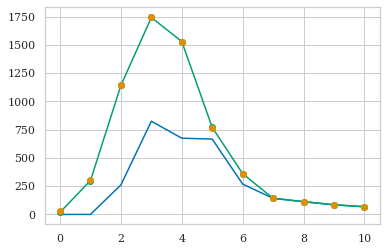

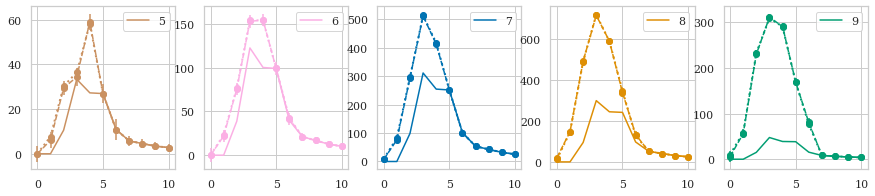

In [31]:

########################   
##Extrapolate
##
region = 'Bergamo'
scale = deathscaling2['Bergamo']
print(scale)


valsw = np.array(bergamodata[0] + np.diff(bergamodata).tolist())
extrapcovid[region] = valsw

means = controlsyr[region].mean(axis=0)
ddata = data[region].copy()
meancond, errcond = pcavals[region]
meancond = meancond  *l2020*scale
errcond = errcond * l2020*scale
scmpred =  scm[region]*l2020*deathscaling2[region]
pcmean, pcerr = pcafits[region]
pcmean = pcmean  *l2020*scale
pcerr = pcerr * l2020*scale


ddata = ddata*l2020*scale
excess = (ddata - meancond) 
excessscm = (ddata - scmpred)
excesspca = (ddata - pcmean) 

#Extraphere
toapp = ((data1[region] - scm1[region])*datascaling1[region]).tolist()[-2:]
extrapscmmean[region] = np.concatenate([excessscm[-Td:], toapp, valsw[Td2:]])
ratio = extrapscmmean[region][-4]/extrapscmmean[region][-4]
extrapscmmean[region] = np.concatenate([excessscm[-Td:], toapp, valsw[Td2:]])
extrapscmmeanflat[region] = extrapscmmean[region].copy()
ratio = extrapscmmean[region][Td2-1]/extrapcovid[region][Td2-1]
extrapscmmeanflat[region][Td2:] = extrapscmmeanflat[region][Td2:] * ratio
    
    
meancond1, errcond1 = pcavals1[region]
toapp = ((data1[region] - meancond1)*datascaling1[region]).tolist()[-2:]
extrapcgpmean[region] = np.concatenate([excess[-Td:], toapp, valsw[Td2:]])
toapp = (errcond1*datascaling1[region]).tolist()[-2:]
extrapcgpmeaner[region] = np.concatenate([errcond1[-Td:], toapp, valsw[Td2:]**0.5])
extrapcgpmeanflat[region] = extrapcgpmean[region].copy()
ratio = extrapcgpmeanflat[region][Td2-1]/extrapcovid[region][Td2-1]
extrapcgpmeanflat[region][Td2:] = extrapcgpmeanflat[region][Td2:] * ratio
extrapcgpmeanflater[region] = extrapcgpmeaner[region].copy()
extrapcgpmeanflater[region][Td2:] = extrapcgpmeanflater[region][Td2:]*ratio**0.5

    
pcmean1, pcerr1 = pcafits1[region]
toapp = ((data1[region] - pcmean1)*datascaling1[region]).tolist()[-2:]
extrappcfits[region] = np.concatenate([excesspca[-Td:], toapp, valsw[Td2:]])
toapp = (pcerr1*datascaling1[region]).tolist()[-2:]
extrappcfitser[region] = np.concatenate([pcerr[-Td:], toapp, valsw[Td2:]**0.5])

extrapcovid['Bergamo'] = np.diff(bergamodata)

xplot = np.arange(valsw.size)
plt.plot(xplot, valsw)
plt.errorbar(xplot, extrapcgpmean['Bergamo'], extrapcgpmeaner['Bergamo'], fmt='o')
plt.plot(xplot, extrapscmmean['Bergamo'], marker='o')
# plt.plot(excess,)
plt.show()

plt.figure(figsize=(15, 3))
for ia, age in enumerate(range(10)):
    key = 'Bergamo%d'%age

    
    frac = bergamoagedata[age]/bergamoagedata.sum()
    valsw = np.array(bergamodata[0] + np.diff(bergamodata).tolist()) * frac
    aextrapcovid[key] = valsw

    means = acontrols[key].mean(axis=0)
    ddata = adata[key].copy()

    meancond, errcond = apcavals[key]
    meancond = meancond.copy()*l2020*scale
    errcond = errcond.copy()*l2020*scale
    scmpred = ascm[key]*l2020*scale
    ddata = ddata *l2020*scale
    pcmean, pcerr = apcafits[key]
    pcmean = pcmean  *l2020*scale
    pcerr = pcerr * l2020*scale

    excess = (ddata - meancond) 
    excessscm = (ddata - scmpred) 
    excesspca = (ddata - pcmean) 

    #Extraphere
    toapp = ((adata1[key] - ascm1[key])*datascaling1[region]).tolist()[-2:]
    aextrapscmmean[key] = np.concatenate([excessscm[-Td:], toapp, valsw[Td2:]]) 
    #
    aextrapscmmean[key][aextrapscmmean[key] < valsw] = valsw[aextrapscmmean[key] < valsw]

    meancond1, errcond1 = apcavals1[key]
    toapp = ((adata1[key] - meancond1)*datascaling1[region]).tolist()[-2:]
    aextrapcgpmean[key] = np.concatenate([excess[-Td:], toapp, valsw[Td2:]])
    toapp = (errcond1*datascaling1[region]).tolist()[-2:]
    aextrapcgpmeaner[key] = np.concatenate([errcond[-Td:], toapp, valsw[Td2:]**0.5])
    #
    aextrapcgpmean[key][aextrapcgpmean[key] < valsw] = valsw[aextrapcgpmean[key] < valsw]
    aextrapcgpmeaner[key][aextrapcgpmean[key] < valsw] = valsw[aextrapcgpmean[key] < valsw]**0.5
    
    
    pcmean1, pcerr1 = apcafits1[key]
    toapp = ((adata1[key] - pcmean1)*datascaling1[region]).tolist()[-2:]
    aextrappcfits[key] = np.concatenate([excesspca[-Td:], toapp, valsw[Td2:]])
    toapp = (pcerr1*datascaling1[region]).tolist()[-2:]
    aextrappcfitser[key] = np.concatenate([pcerr[-Td:], toapp, valsw[Td2:]**0.5])
    #
    aextrappcfits[key][aextrappcfits[key] < valsw] = valsw[aextrappcfits[key] < valsw]
    aextrappcfitser[key][aextrappcfits[key] < valsw] = valsw[aextrappcfits[key] < valsw]**0.5

    
    if age > 4:
        plt.subplot(150+(age-4))
        xplot = np.arange(valsw.size)
        plt.plot(xplot, valsw, label=age, color='C%d'%(age%7))
        plt.errorbar(xplot, aextrapcgpmean[key], aextrapcgpmeaner[key], ls="--", fmt='o', color='C%d'%(age%7))
        plt.plot(xplot, aextrapscmmean[key], marker='o', ls=":", lw=2, color='C%d'%(age%7))
        # plt.plot(excess,)
        plt.legend()
    aextrapcovid['Bergamo%d'%age] = np.diff(bergamodata) * frac


# Get lower bound on IFR from the extrapolated data

In [32]:
#Regions to plot

mainregionsb = np.unique(dfmort['region'])[[4, 7, 8, 9, 11,  15, 19]].tolist() + ['Bergamo']
# mainregionsb = [i for i in mainregions if i != 'Sardegna'] + ['Bergamo']
print(mainregionsb)
mainregions = np.unique(dfmort['region'])[[4, 7, 8, 9, 11, 15, 16, 19]].tolist() + ['Bergamo']
print(mainregions)


['Emilia-Romagna', 'Liguria', 'Lombardia', 'Marche', 'Piemonte', 'Toscana', 'Veneto', 'Bergamo']
['Emilia-Romagna', 'Liguria', 'Lombardia', 'Marche', 'Piemonte', 'Toscana', 'Trentino-Alto Adige/Südtirol', 'Veneto', 'Bergamo']


Text(0, 0.5, 'total_cases/swabs')

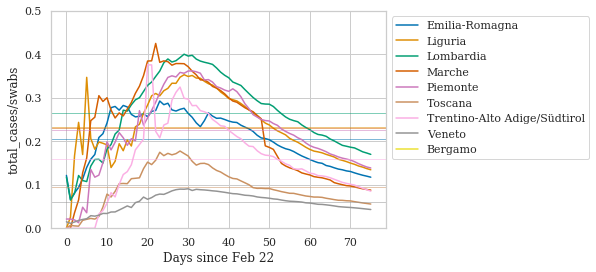

In [33]:
# Plot number of swabs to visualize the maximum TPR

region = 'Lombardia'
for ir, region in enumerate(mainregions):
    tmp = dfcovid[dfcovid['region'] == region]
    plt.plot((tmp['total_cases']/tmp['swabs']).values, 'C%d'%ir, label=region)
    plt.axhline((tmp['total_cases']/tmp['swabs']).values.mean(), color='C%d'%ir, lw=0.5)
#     plt.plot((np.diff(tmp['total_cases'].values)/np.diff(tmp['swabs'].values)))
plt.ylim(0, 0.5)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Days since Feb 22")
plt.ylabel('total_cases/swabs')

Text(0.5, 0.98, 'Infection Fatality Rate (in %) from cumulative statistics since the intervention at T=T0)')

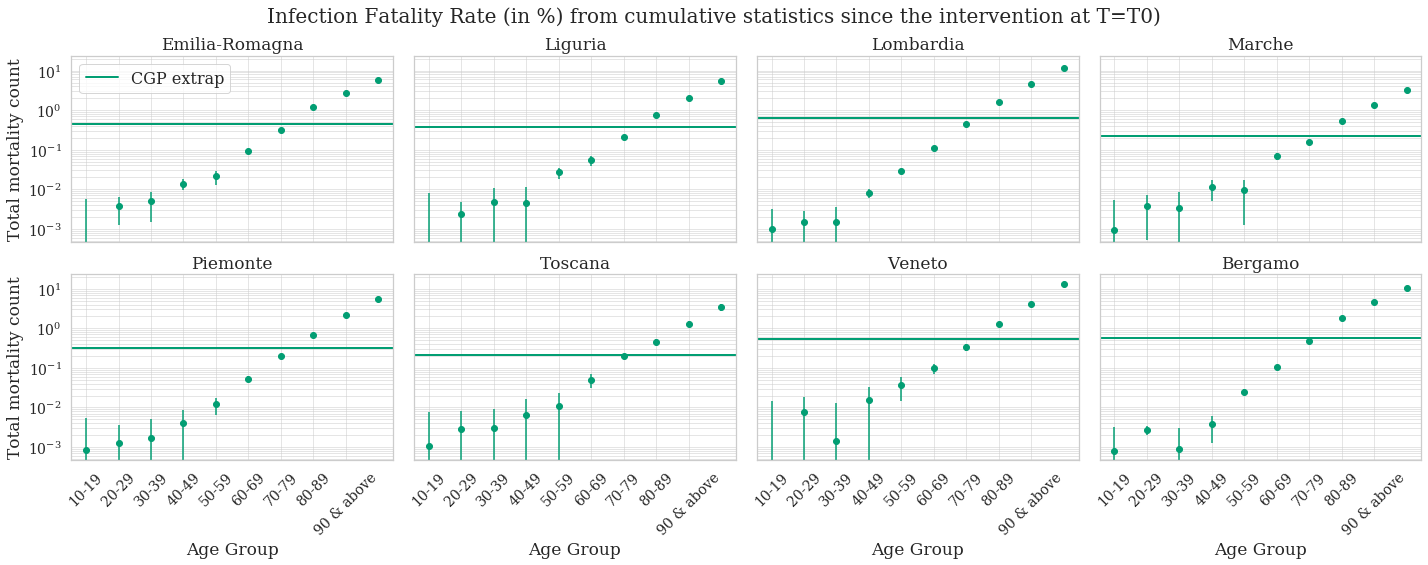

In [34]:
xlab = [i.split('-')[0][:-5] for i in w2020]     

fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
axf = ax.flatten()
axn = 0
i0 = T0
mss = ['^', 'v', 's', 's','1', '2', '3', '4', 'P', 'd']

axn = 0 

ifrcgp_ex, ifrcgper_ex = {}, {}
ifrtot_ex  = {}
# cfrcvd_ex  = {}
fpositive_ex = {}

for ir, region in enumerate(np.append(regions, 'Bergamo')):
    
    scale = deathscaling2[region]

    pop = dfpop[dfpop['region'] == region]['total_population'].values[0]
    if region == 'Bergamo' : fpos = 1
    else:
        tmp = dfcovid[dfcovid['region'] == region]
        datepos = [ i for i in np.arange(tmp['date'].values.size) if dateextrap in tmp['date'].values[i]][0]
        tmp = tmp[10:datepos+1]
        fpos = ((tmp[:]['total_cases']/tmp[:]['swabs']).values).max()
        
    ###
    lbl = 'CGP extrap'
    excess = extrapcgpmean[region].sum() 
    infection_rate = excess / pop /fpos *100
    excesser = extrapcgpmeaner[region].sum() 
    infection_rateer = excesser / pop /fpos *100
    if region in mainregionsb and region != 'Sardegna':
        axf[axn].axhline(infection_rate, color='C2', label=lbl, alpha=1, lw=2)

#     cfrcvd_ex[region] = infection_ratecvd
    ifrtot_ex[region] = [infection_rate, infection_rateer]
    fpositive_ex[region] = [fpos]

    ircgp, ircgper = [], []
    for ia, age in enumerate(range(10)):
        key = region + '%d'%age

        #########
        lbl = None
        if axn == 1: lbl = agegroups[age]

        pop = dfpop[dfpop['region'] == region]['total_population'].values[0]
        agedist =  dfagedist[dfagedist['region'] == region].values[0][1:].astype(float)
        agedist = agedist/agedist.sum()
        pop *= agedist[age]
        excess = aextrapcgpmean[key].sum() 
        infection_rate = excess / pop /fpos *100
        err = (aextrapcgpmeaner[key]**2).sum()**0.5
        err = err / pop /fpos *100            

        ircgp.append(infection_rate)
        ircgper.append(err)

    ifrcgp_ex[region] = np.array(ircgp)
    ifrcgper_ex[region] = np.array(ircgper)

    if region in mainregionsb:
        if region == 'Sardegna': continue
        xx = np.arange(len(agegroups[:]))
        axf[axn].errorbar(xx, ircgp, ircgper, fmt='o', color='C2', alpha=1)

        #######
        if axn ==0 : axf[axn].legend(fontsize=16, ncol=1, loc=2)
        axf[axn].grid(which = 'both', lw=0.5)
        axf[axn].set_title(region, fontsize=17)
        axn +=1


for axis in ax[-1,:]:
    axis.set_xticks(np.arange(len(agegroups[1:])))
    axis.set_xticklabels(agegroups[1:])
    axis.set_xlabel('Age Group', fontsize=17)
for axis in ax[:,0]:
    axis.set_ylabel('Total mortality count', fontsize=17)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.yscale('log')
#     plt.axhline(0, color='k', lw=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Infection Fatality Rate (in %) from cumulative statistics since the intervention at T=T0)', fontsize=20)

# Make final figures for the paper

## Fig. 4 - Missed fraction

index -1 is out of bounds for axis 0 with size 0


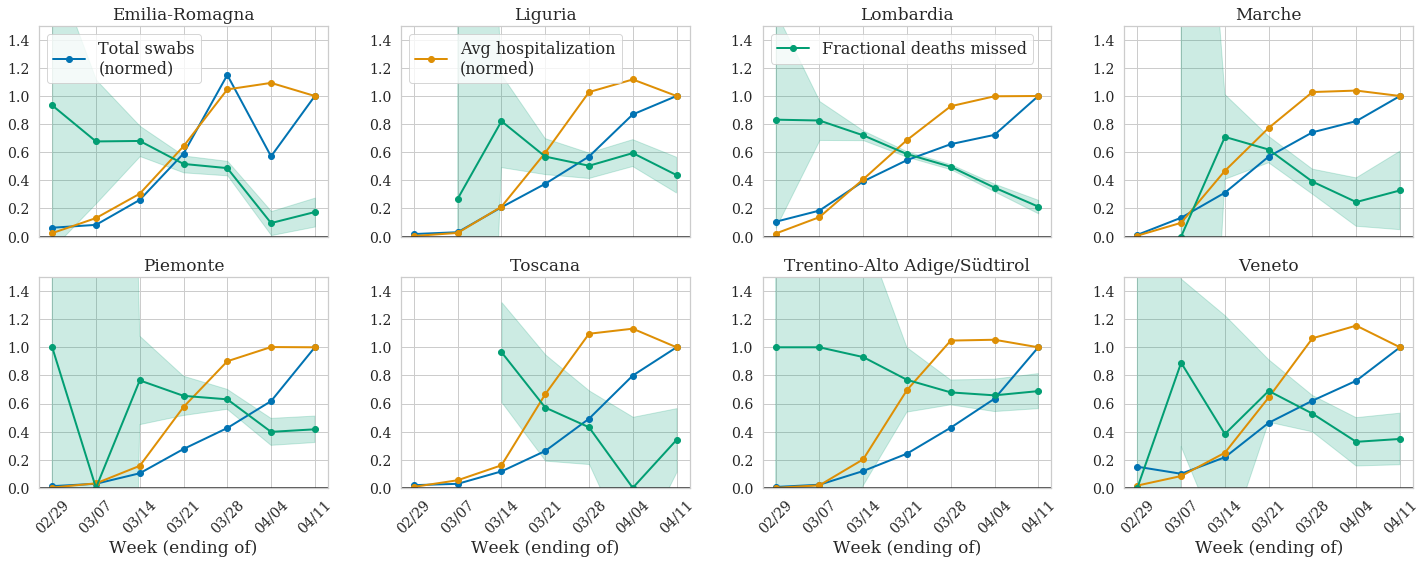

In [35]:
isplit = [6] + [6+i*7 for i in range(1, 7)]
xlab = [i[-1] for i in np.split(dfcovid[dfcovid['region'] == 'Lombardia']['date'].values, isplit)][:-1]
xlab = [i.split('-')[1]+'/'+i.split('-')[2].split('T')[0] for i in xlab]
i0 = 0 

fig, ax = plt.subplots(2, 4, figsize = (20, 8), sharex=True)
axf = ax.flatten()
axn = 0 
for ir, rr in enumerate(mainregions):
    try:
        ss = np.array([i[-1] for i in np.split(dfcovid[dfcovid['region'] == rr]['swabs'].values, isplit)][:-1])
        ss = np.array([ss[0]] + list(np.diff(ss)))
        hh = np.array([i[-1] for i in np.split(dfcovid[dfcovid['region'] == rr]['hospitalized'].values, isplit)][:-1])
        excess = extrapcgpmean[rr]-extrapcovid[rr]
        excessratio = extrapcgpmean[rr]/extrapcovid[rr]
        excessfrac = excess / extrapcgpmean[rr]
        excessfrac = (excess / extrapcgpmean[rr])[:-2]
        excessfracer = (extrapcgpmeaner[rr] / extrapcgpmean[rr])[:-2]
        
        lbl = None
        if axn == 0: lbl = 'Total swabs\n(normed)'
#         axf[axn].plot(ss/ss.max(),  '-o', label=lbl)
        axf[axn].plot(ss/ss[-1],  '-o', label=lbl, lw=2)
        
        lbl = None
        if axn == 1: lbl = 'Avg hospitalization\n(normed)'
        axf[axn].plot(hh/hh[-1],  '-o', label=lbl, lw=2)
#         axf[axn].plot(hh/hh.max(),  '-o', label=lbl)
        
        lbl = None
        if axn == 2: lbl = 'Fractional deaths missed'
#         axf[axn].plot(xplot, excess/excess.max(), marker='o',  ls="--", label=lbl)
#         axf[axn].plot(xplot, excessratio-1, marker='o',  ls="--", label=lbl)
        axf[axn].plot(xplot[:Td2], excessfrac[:Td2], 'C2-o', label=lbl, lw=2)
#         axf[axn].plot(xplot[-4:-2], excessfrac[-2:], 'C2--o', lw=2)
        axf[axn].fill_between(xplot[:Td2], excessfrac[:Td2] - excessfracer[:Td2], 
                              excessfrac[:Td2] + excessfracer[:Td2], color='C2', alpha=0.2)
        axf[axn].set_title(rr, fontsize=17)
        axf[axn].axhline(0, color='k')
        axf[axn].set_ylim(0, 1.5)
        if axn in [0, 1, 2]: axf[axn].legend(fontsize=16, loc=2)
        axn += 1
    except Exception as e: print(e)

for axis in ax[-1,:]:
#     axis.set_xticks(np.arange(data[region].size)[i0::2])
    axis.set_xticks(np.arange(len(xlab))[i0::1])
    axis.set_xticklabels(xlab[i0::1])
    axis.set_xlabel('Week (ending of)', fontsize=17)
# for axis in ax[:,0]:
#     axis.set_ylabel('Weekly mortality', fontsize=18)

for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
#     plt.axhline(0, color='k', lw=0.5)

plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle('Validating the counterfactual prediction on the pre-intervention data', fontsize=20)
# plt.savefig('../paper_figs/missed_fraction.pdf')
# plt.savefig('../paper_figs/missed_fraction.jpeg', dpi=300)
plt.show()

    

## Fig. 1 - Plot counterfactuals

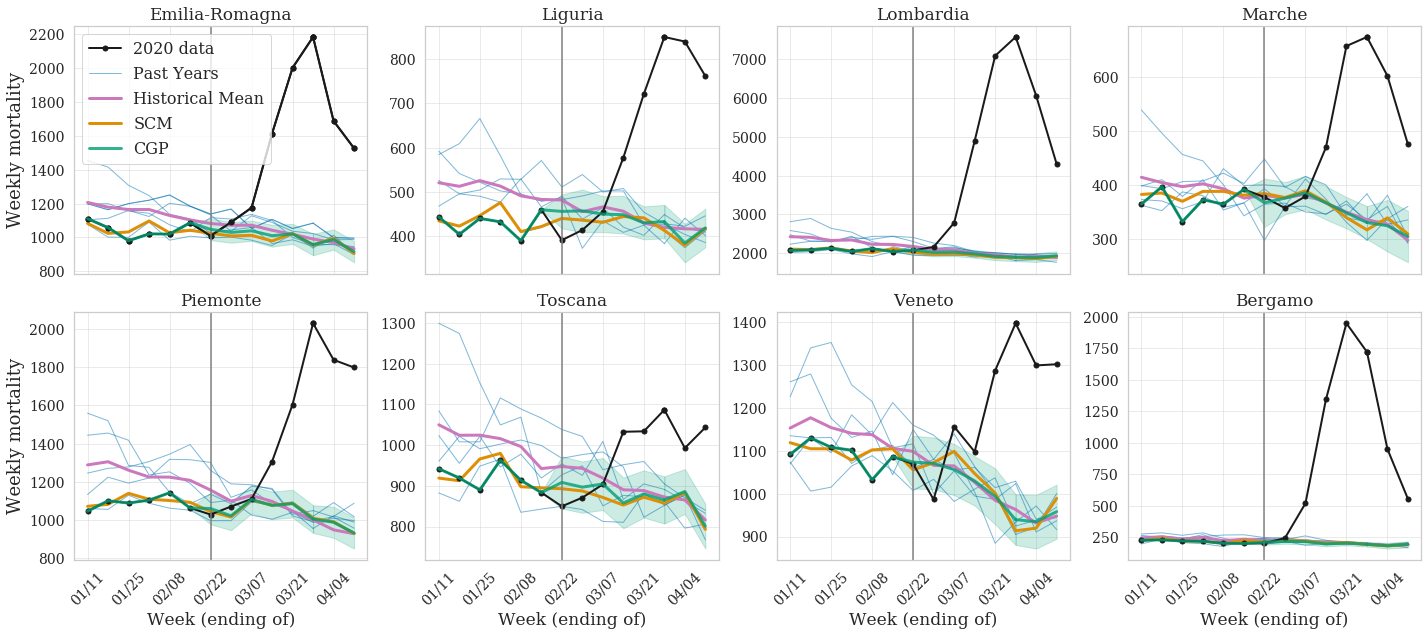

In [36]:
###  plot counterfactuals

l20202 = l2020.copy()
l202021 = l20201.copy()
l20202[0] = 7
l202021[0] = 7

xlab = [i.split('-')[1][:-5] for i in w20201]     
xlab = [i.split('/')[1]+'/'+i.split('/')[0] for i in xlab]     
# xlab = [i.split('-')[1][:-5] for i in w20201]     
# xlab = [i.split('/')[1]+'/'+i.split('/')[0] for i in xlab]     

fig, ax = plt.subplots(2, 4, figsize=(20, 9), sharex=True)
axf = ax.flatten()
axn = 0
i0 = 0

for ir, region in enumerate(mainregionsb):

    scale = deathscaling2[region]
    scale1 = datascaling1[region]
    
    if region in mainregionsb : 
        if region == 'Puglia' : continue
        lbl = region
        ddata = (data[region])*scale * l20202 
        ddata1 = (data1[region])*scale1 
        x = np.arange(ddata.size)
        i1 = x.size-1
        x1 = np.arange(ddata1.size)
        ddata1[i1] = ddata[-1]
        lbl = None
        
        if axn == 0: 
            lbl = '2020 data'        
            axf[axn].plot(x, ddata, 'k', label=lbl, marker='o', lw=2, alpha=1, markersize=5)
            axf[axn].plot(x1[i1:], ddata1[i1:], 'k',  marker='o', lw=2, alpha=1, markersize=5)
        
        if axn == 0: lbl = None        
        dd = (controlsyr[region] *scale * l20202).T
        axf[axn].plot(x[i0:], dd[:, i0:], color='C0', lw=1, alpha=0.5, label=lbl)
        if ir == 0: axf[axn].plot(x[i0:], dd[:, 0], color='C0', lw=1, alpha=0.5, label='Past Years')
        #
        dd1 = (controlsyr1[region] *deathscaling1[region] * l20201).T
        dd1[i1] = dd[-1]
        axf[axn].plot(x1[i1:], dd1[i1:, :], color='C0', lw=1, alpha=0.5, label=lbl)
        if ir == 0: axf[axn].plot(x1[i1:], dd1[i1:, 0], color='C0', lw=1, alpha=0.5)

        if axn == 0: lbl = 'Historical Mean'        
        means = controlsyr[region].mean(axis=0)
        dd = (means*scale * l20202)
        err = np.cov((controlsyr[region]).T).diagonal()**0.5 *scale * l20202
        axf[axn].plot(x[i0:], dd[i0:], color='C4', lw=3, alpha=1, label=lbl)
        #
        means1 = controlsyr1[region].mean(axis=0)
        dd1 = (means1*scale1)
        dd1[i1] = dd[-1]
        axf[axn].plot(x1[i1:], dd1[i1:], color='C4', lw=3, alpha=1)
    

        if axn == 0: lbl = 'SCM'        
        dd = (scm[region]*scale * l20202) 
        axf[axn].plot(x[i0:], dd[i0:], 'C1', lw=3, alpha=1, label=lbl)
        #
        dd1 = (scm1[region]*scale1) 
        dd1[i1] = dd[-1]
        axf[axn].plot(x1[i1:], dd1[i1:], 'C1', lw=3, alpha=1)

        if axn == 0: lbl = 'CGP'
        meancond, errcond  = pcavals[region]
        dd = (meancond * scale * l20202) 
        err = errcond*scale*l20202
        axf[axn].errorbar(x[i0:], dd[i0:],  ls="-", color='C2', lw=3, alpha=0.8, label=lbl)
        axf[axn].fill_between(x[i0:], dd[i0:]-err[i0:], dd[i0:]+err[i0:], color='C2', alpha=0.2)
        #
        meancond, errcond1  = pcavals1[region]
        dd1 = (meancond * scale1) 
        err1 = errcond1*scale1
        dd1[i1] = dd[-1]
        err1[i1] = err[-1]
        axf[axn].errorbar(x1[i1:], dd1[i1:],  ls="-", color='C2', lw=3, alpha=0.8)
        axf[axn].fill_between(x1[i1:], dd1[i1:]-err1[i1:], dd1[i1:]+err1[i1:], color='C2', alpha=0.2)

#         if axn == 0: lbl = 'PCA2'
#         ppred, perr = pcafits[region]
#         dd = (ppred * scale * l20202) 
# #         dd = ddata - dd
#         err = perr*scale*l20202
#         axf[axn].errorbar(x[i0:], dd[i0:],  ls="-", color='C7', lw=3, alpha=0.8, label=lbl)
#         axf[axn].fill_between(x[i0:], dd[i0:]-err[i0:], dd[i0:]+err[i0:], color='C7', alpha=0.2)
        
        
        lbl = None        
        axf[axn].plot(x, ddata, 'k', label=lbl, marker='o', lw=2, alpha=1, markersize=5)
        axf[axn].plot(x1[i1:], ddata1[i1:], 'k',  marker='o', lw=2, alpha=1, markersize=5)
#         dd = (data[region])*scale * l20202 
#         axf[axn].plot(dd, 'k', label=lbl, marker='o', lw=2, alpha=1, markersize=5)

        axf[axn].axvline(x[T0], color='gray')
        if axn == 0: axf[axn].legend(fontsize=16, ncol=1)
        axf[axn].grid(which = 'both', lw=0.5, alpha=0.8)
        axf[axn].set_title(region, fontsize=17)
        axn +=1

for axis in ax[-1,:]:
#     axis.set_xticks(np.arange(data[region].size)[i0::2])
    axis.set_xticks(np.arange(len(xlab))[i0::2])
    axis.set_xticklabels(xlab[i0::2])
    axis.set_xlabel('Week (ending of)', fontsize=17)
for axis in ax[:,0]:
    axis.set_ylabel('Weekly mortality', fontsize=18)
# fig.text(0.0, 0.55, 'Weekly mortality', ha='center', va='center', rotation='vertical', fontsize=19)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
#     plt.axhline(0, color='k', lw=0.5)
    
plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle('Validating the counterfactual prediction on the pre-intervention data', fontsize=20)
# plt.savefig('../paper_figs/counterfactuals.pdf')
# plt.savefig('../paper_figs/counterfactuals.jpeg', dpi=300)
plt.show()

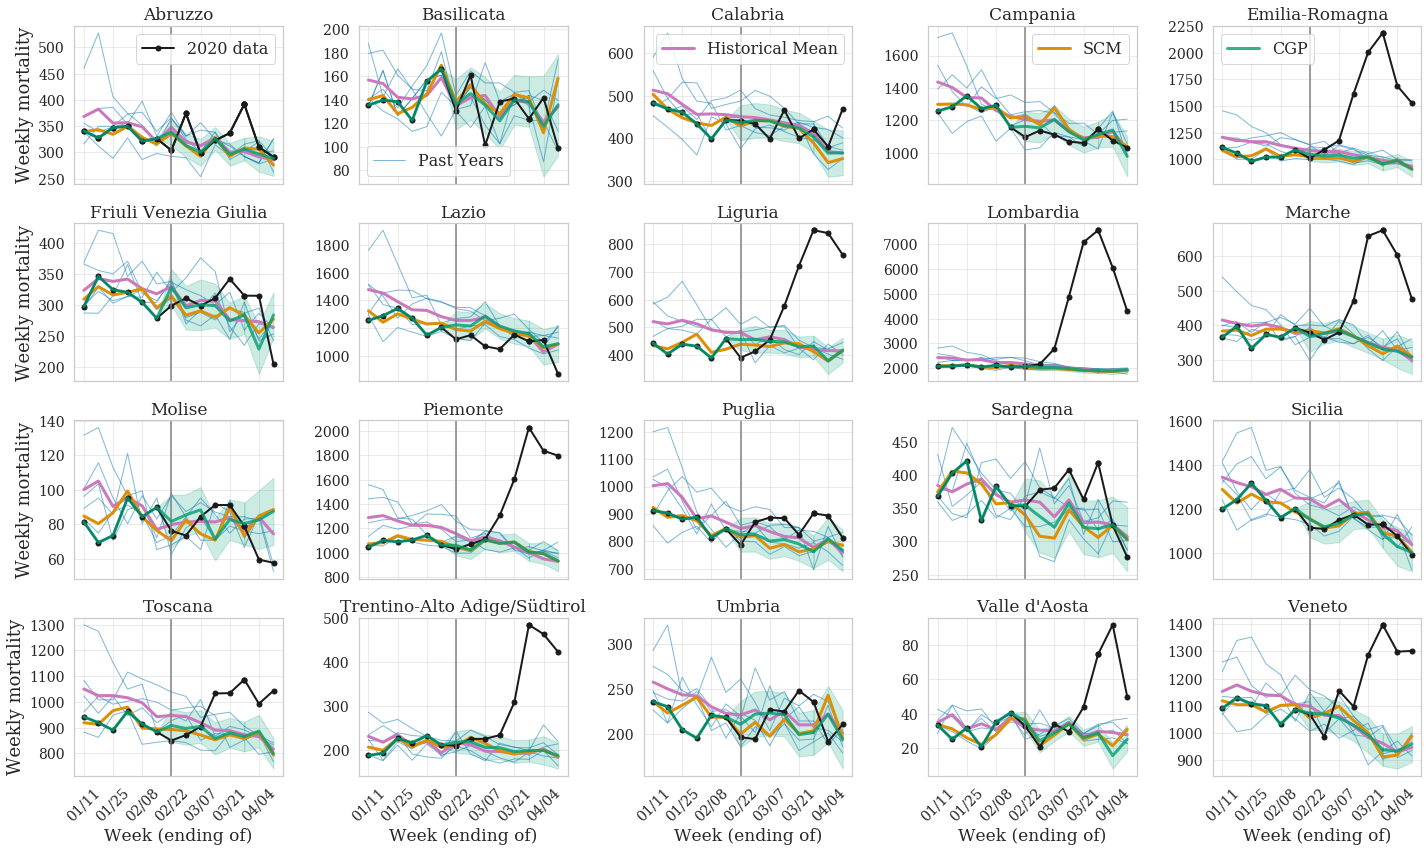

In [37]:
###  plot counterfactuals

l20202 = l2020.copy()
l202021 = l20201.copy()
l20202[0] = 7
l202021[0] = 7

xlab = [i.split('-')[1][:-5] for i in w20201]     
xlab = [i.split('/')[1]+'/'+i.split('/')[0] for i in xlab]     

fig, ax = plt.subplots(4, 5, figsize=(20, 12), sharex=True)
axf = ax.flatten()
axn = 0
i0 = 0

for ir, region in enumerate(regions):

    scale = deathscaling2[region]
    scale1 = datascaling1[region]
    
    if region in regions : 
#         if region == 'Puglia' : continue
        lbl = region
        ddata = (data[region])*scale * l20202 
        ddata1 = (data1[region])*scale1 
        x = np.arange(ddata.size)
        i1 = x.size-1
        x1 = np.arange(ddata1.size)
        ddata1[i1] = ddata[-1]
        lbl = None
        
        if axn == 0: 
            lbl = '2020 data'        
            axf[axn].plot(x, ddata, 'k', label=lbl, marker='o', lw=2, alpha=1, markersize=5)
            axf[axn].plot(x1[i1:], ddata1[i1:], 'k',  marker='o', lw=2, alpha=1, markersize=5)
        
        if axn == 0: lbl = None        
        dd = (controlsyr[region] *scale * l20202).T
        axf[axn].plot(x[i0:], dd[:, i0:], color='C0', lw=1, alpha=0.5, label=lbl)
        if ir == 1: axf[axn].plot(x[i0:], dd[:, 0], color='C0', lw=1, alpha=0.5, label='Past Years')
        #
        dd1 = (controlsyr1[region] *deathscaling1[region] * l20201).T
        dd1[i1] = dd[-1]
        axf[axn].plot(x1[i1:], dd1[i1:, :], color='C0', lw=1, alpha=0.5, label=lbl)
        if ir == 0: axf[axn].plot(x1[i1:], dd1[i1:, 0], color='C0', lw=1, alpha=0.5)

        lbl = None
        if axn == 2: lbl = 'Historical Mean'        
        means = controlsyr[region].mean(axis=0)
        dd = (means*scale * l20202)
        err = np.cov((controlsyr[region]).T).diagonal()**0.5 *scale * l20202
        axf[axn].plot(x[i0:], dd[i0:], color='C4', lw=3, alpha=1, label=lbl)
        #
        means1 = controlsyr1[region].mean(axis=0)
        dd1 = (means1*scale1)
        dd1[i1] = dd[-1]
        axf[axn].plot(x1[i1:], dd1[i1:], color='C4', lw=3, alpha=1)
    

        lbl = None
        if axn == 3: lbl = 'SCM'        
        dd = (scm[region]*scale * l20202) 
        axf[axn].plot(x[i0:], dd[i0:], 'C1', lw=3, alpha=1, label=lbl)
        #
        dd1 = (scm1[region]*scale1) 
        dd1[i1] = dd[-1]
        axf[axn].plot(x1[i1:], dd1[i1:], 'C1', lw=3, alpha=1)

        lbl = None
        if axn == 4: lbl = 'CGP'
        meancond, errcond  = pcavals[region]
        dd = (meancond * scale * l20202) 
        err = errcond*scale*l20202
        axf[axn].errorbar(x[i0:], dd[i0:],  ls="-", color='C2', lw=3, alpha=0.8, label=lbl)
        axf[axn].fill_between(x[i0:], dd[i0:]-err[i0:], dd[i0:]+err[i0:], color='C2', alpha=0.2)
        #
        meancond, errcond1  = pcafits1[region]
        dd1 = (meancond * scale1) 
        err1 = errcond1*scale1
        dd1[i1] = dd[-1]
        err1[i1] = err[-1]
        axf[axn].errorbar(x1[i1:], dd1[i1:],  ls="-", color='C2', lw=3, alpha=0.8)
        axf[axn].fill_between(x1[i1:], dd1[i1:]-err1[i1:], dd1[i1:]+err1[i1:], color='C2', alpha=0.2)

#         if axn == 0: lbl = 'PCA2'
#         ppred, perr = pcafits[region]
#         dd = (ppred * scale * l20202) 
# #         dd = ddata - dd
#         err = perr*scale*l20202
#         axf[axn].errorbar(x[i0:], dd[i0:],  ls="-", color='C7', lw=3, alpha=0.8, label=lbl)
#         axf[axn].fill_between(x[i0:], dd[i0:]-err[i0:], dd[i0:]+err[i0:], color='C7', alpha=0.2)
        
        
        lbl = None        
        axf[axn].plot(x, ddata, 'k', label=lbl, marker='o', lw=2, alpha=1, markersize=5)
        axf[axn].plot(x1[i1:], ddata1[i1:], 'k',  marker='o', lw=2, alpha=1, markersize=5)
#         dd = (data[region])*scale * l20202 
#         axf[axn].plot(dd, 'k', label=lbl, marker='o', lw=2, alpha=1, markersize=5)

        axf[axn].axvline(x[T0], color='gray')
        if axn <5: axf[axn].legend(fontsize=16, ncol=1)
        axf[axn].grid(which = 'both', lw=0.5, alpha=0.8)
        axf[axn].set_title(region, fontsize=17)
        axn +=1

for axis in ax[-1,:]:
#     axis.set_xticks(np.arange(data[region].size)[i0::2])
    axis.set_xticks(np.arange(len(xlab))[i0::2])
    axis.set_xticklabels(xlab[i0::2])
    axis.set_xlabel('Week (ending of)', fontsize=17)
for axis in ax[:,0]:
    axis.set_ylabel('Weekly mortality', fontsize=18)
# fig.text(0.0, 0.55, 'Weekly mortality', ha='center', va='center', rotation='vertical', fontsize=19)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
#     plt.axhline(0, color='k', lw=0.5)
    
plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle('Validating the counterfactual prediction on the pre-intervention data', fontsize=20)
# plt.savefig('../paper_figs/counterfactuals_all.pdf')
# plt.savefig('../paper_figs/counterfactuals_all.jpeg', dpi=300)
plt.show()

## Fig. 2a - Plot weekly residuals for population


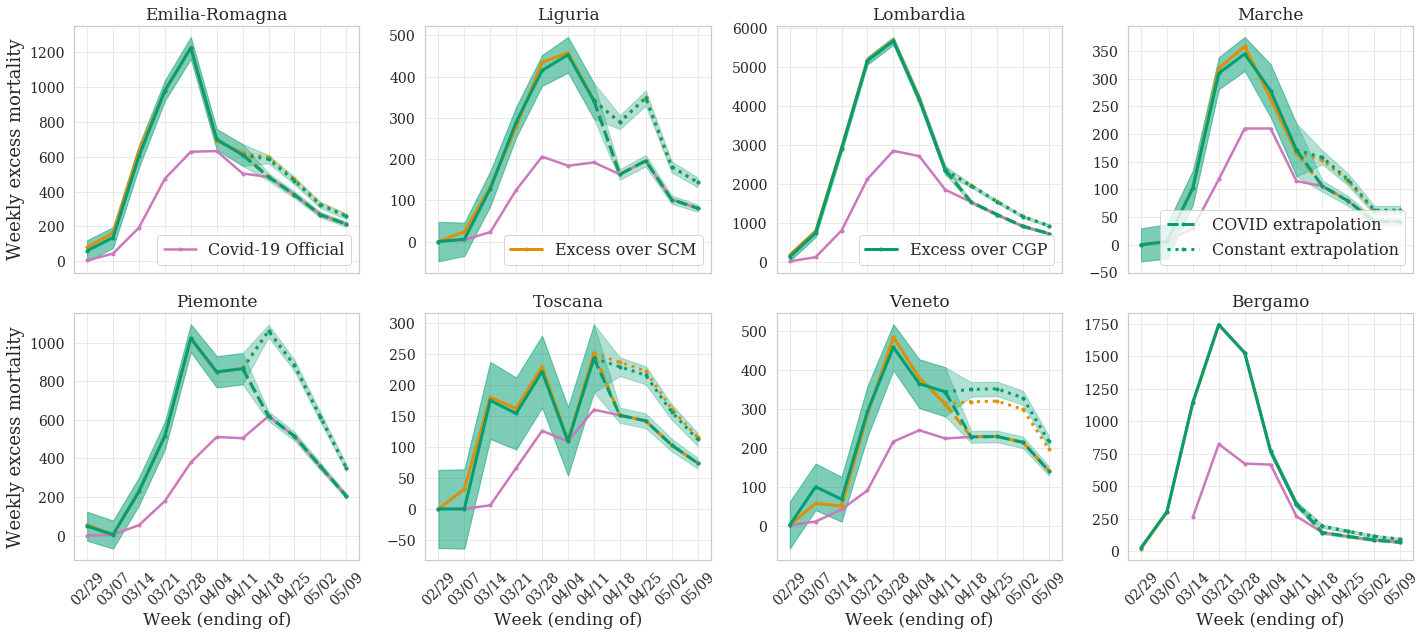

In [38]:
###  plot weekly residuals for population


# Td = 5 #number of data points we have
# Td2 = Td + 2
# nextrap = 9
    

dateextrap = "2020-05-02"
isplit = [6] + [6+i*7 for i in range(1, nextrap)]
xlab = [i[6]  if i.size >=7 else i[-1] for i in np.split(dfcovid[dfcovid['region'] == 'Lombardia']['date'].values, isplit)]
xlab = [i.split('-')[1]+'/'+i.split('-')[2].split('T')[0] for i in xlab]
# xlab[-1] = '%s/%s'%(dateextrap.split('-')[1], dateextrap.split('-')[2])



fig, ax = plt.subplots(2, 4, figsize=(20, 9), sharex=True)
axf = ax.flatten()
axn = 0 
i0 = T0+1
normi0 = False

for ir, region in enumerate(mainregionsb):
    if axn < 8:
        if region == 'Puglia' : continue
        scale = deathscaling2[region]
        key = region
        xplot = np.arange(extrapcovid[key].size)


        lbl = None
        if axn == 0: lbl = "Covid-19 Official"
        yy = extrapcovid[key]
        if region == 'Bergamo': axf[axn].plot(xplot[2:], yy[2:], marker='.', lw=2.5, color='C4', label=lbl)
        else: axf[axn].plot(xplot, yy, marker='.', lw=2.5, color='C4', label=lbl)
        #

        lbl = None
        if axn == 1: lbl = "Excess over SCM"
        dd = extrapscmmean[key]
        ddflat = extrapscmmeanflat[key]
        axf[axn].errorbar(xplot[:Td2], dd[:Td2], 
                          color='C1', ls = "-", marker='.', lw=3, label=lbl)
        axf[axn].errorbar(xplot[Td2-1:], dd[Td2-1:], 
                          color='C1', ls = "--", marker='.', lw=3)
        axf[axn].errorbar(xplot[Td2-1:], ddflat[Td2-1:], 
                          color='C1', ls = ":", marker='.', lw=3)
        

        lbl = None
        if axn == 2: lbl = "Excess over CGP"
        dd = extrapcgpmean[key]
        ddflat = extrapcgpmeanflat[key]
        axf[axn].errorbar(xplot[:Td2], dd[:Td2],  
                          color='C2', ls = "-", marker='.', lw=3, label=lbl)
        lbl = None
        if axn == 3: lbl = "COVID extrapolation"
        axf[axn].errorbar(xplot[Td2-1:], dd[Td2-1:],  
                          color='C2', ls = "--", marker='.', lw=3, label=lbl)
        lbl = None
        if axn == 3: lbl = "Constant extrapolation"
        axf[axn].errorbar(xplot[Td2-1:], ddflat[Td2-1:],  
                          color='C2', ls = ":", marker='.', lw=3, label=lbl)
        axf[axn].fill_between(xplot, 
                              dd - extrapcgpmeaner[key], 
                              dd + extrapcgpmeaner[key], 
                              color='C2', alpha=0.3)
        axf[axn].fill_between(xplot, 
                              ddflat - extrapcgpmeanflater[key], 
                              ddflat + extrapcgpmeanflater[key], 
                              color='C2', alpha=0.3)

#         if axn == 0: lbl = 'PCA2'
#         dd = extrappcfits[region]
#         dderr = extrappcfitser[region]
#         axf[axn].errorbar(xplot[:Td], dd[:Td],  
#                           color='C7', ls = "-", marker='.', lw=3, label=lbl)
#         axf[axn].errorbar(xplot[Td-1:], dd[Td-1:],  
#                           color='C7', ls = "--", marker='.', lw=3)
#         axf[axn].fill_between(xplot, dd - dderr, dd + dderr, color='C7', alpha=0.2)
        
        

        if axn in [0, 1, 2, 3]: axf[axn].legend(fontsize=16, ncol=1, loc=4)
        axf[axn].grid(which = 'both', lw=0.5, alpha=0.8)
        axf[axn].set_title(region, fontsize=17)
        axn +=1
    

for axis in ax[-1,:]:
    axis.set_xticks(xplot)
    axis.set_xticklabels(xlab)
    axis.set_xlabel('Week (ending of)', fontsize=17)
for axis in ax[:,0]:
    axis.set_ylabel('Weekly excess mortality', fontsize=18)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    
plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle('Residual between predicted and actual weekly mortality for different age groups', fontsize=20)
# plt.savefig('../paper_figs/residuals_weekly.pdf')
# plt.savefig('../paper_figs/residuals_weekly.jpeg')
plt.show()

## Fig. 2b - Plot cumulative residuals for population


In [39]:
###  plot cumulative residuals for population


fig, ax = plt.subplots(2, 4, figsize=(20, 9), sharex=True)
axf = ax.flatten()
axn = 0 
i0 = T0+1
normi0 = False

for ir, region in enumerate(mainregionsb):
    if axn < 8:
        if region == 'Puglia' : continue
        scale = deathscaling2[region]
        key = region
        xplot = np.arange(extrapcovid[key].size)

        lbl = None
        if axn == 0: lbl = "Covid-19 Official"
        yy = np.cumsum(extrapcovid[key])
        if region == 'Bergamo': axf[axn].plot(xplot[2:], yy[2:], marker='.', lw=2.5, color='C4', label=lbl)
        else: axf[axn].plot(xplot, yy, marker='.', lw=2.5, color='C4', label=lbl)
#         axf[axn].plot(xplot, yy, marker='.', lw=3, color='r', label=lbl)
        #
        lbl = None
        if axn == 1: lbl = "Excess over SCM"
        yy = np.cumsum(extrapscmmean[key])
        axf[axn].errorbar(xplot[:Td2], yy[:Td2], 
                          color='C1', ls = "-", marker='.', lw=3, label=lbl)
        axf[axn].errorbar(xplot[Td2-1:], yy[Td2-1:], 
                          color='C1', ls = "--", marker='.', lw=3)
        yy = np.cumsum(extrapscmmeanflat[key])
        axf[axn].errorbar(xplot[Td2-1:], yy[Td2-1:], 
                          color='C1', ls = ":", marker='.', lw=3)

        lbl = None
        if axn == 2: lbl = "Excess over CGP"
        yy = np.cumsum(extrapcgpmean[key])
        yyerr = np.cumsum(extrapcgpmeaner[key]**2)**0.5  * 0
        axf[axn].errorbar(xplot[:Td2], yy[:Td2], yyerr[:Td2], 
                          color='C2', ls = "-", marker='.', lw=3, label=lbl)
        lbl = None
        if axn == 3: lbl = "COVID\nextrapolation"
        axf[axn].errorbar(xplot[Td2-1:], yy[Td2-1:], yyerr[Td2-1:], 
                          color='C2', ls = "--", marker='.', lw=3, label=lbl)
        yyerr = np.cumsum(extrapcgpmeaner[key]**2)**0.5  
        axf[axn].fill_between(xplot, yy-yyerr, yy+yyerr,
                          color='C2', alpha=0.3)

        if axn == 3: lbl = "Constant\nextrapolation"
        yy = np.cumsum(extrapcgpmeanflat[key])
        yyerr = np.cumsum(extrapcgpmeanflater[key]**2)**0.5  
        axf[axn].errorbar(xplot[Td2-1:], yy[Td2-1:], yyerr[Td2-1:]*0, 
                          color='C2', ls = ":", marker='.', lw=3, label=lbl)
        yyerr = np.cumsum(extrapcgpmeaner[key]**2)**0.5  
        axf[axn].fill_between(xplot, yy-yyerr, yy+yyerr,
                          color='C2', alpha=0.3)
        
        lbl = None
#         lbl = None
#         if axn == 3: lbl = "Excess over PCA2"
#         dd = np.cumsum(extrappcfits[region])
#         dderr = np.cumsum(extrappcfitser[region]**2)**0.5
#         axf[axn].errorbar(xplot[:Td], dd[:Td],  dderr[:Td]*0,
#                           color='C7', ls = "-", marker='.', lw=3, label=lbl)
#         axf[axn].errorbar(xplot[Td-1:], dd[Td-1:],  
#                           color='C7', ls = "--", marker='.', lw=3)
#         axf[axn].fill_between(xplot, dd - dderr, dd + dderr, color='C7', alpha=0.2)

    

        if axn in [0, 1, 2, 3]: axf[axn].legend(fontsize=16, ncol=1, loc=0)
        axf[axn].grid(which = 'both', lw=0.5, alpha=0.8)
        axf[axn].set_title(region, fontsize=17)
        axn +=1
    

for axis in ax[-1,:]:
    axis.set_xticks(xplot)
    axis.set_xticklabels(xlab)
    axis.set_xlabel('Week (ending of)', fontsize=17)
for axis in ax[:,0]:
    axis.set_ylabel('Cumulative excess mortality', fontsize=18)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    
plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle('Residual between cumulative predicted and actual weekly mortality', fontsize=20)
# plt.savefig('../paper_figs/residuals_cumulative.pdf')
# plt.savefig('../paper_figs/residuals_cumulative.jpeg')


## Fig. 3 - Plot cumulative residuals for diferent age groups


No handles with labels found to put in legend.


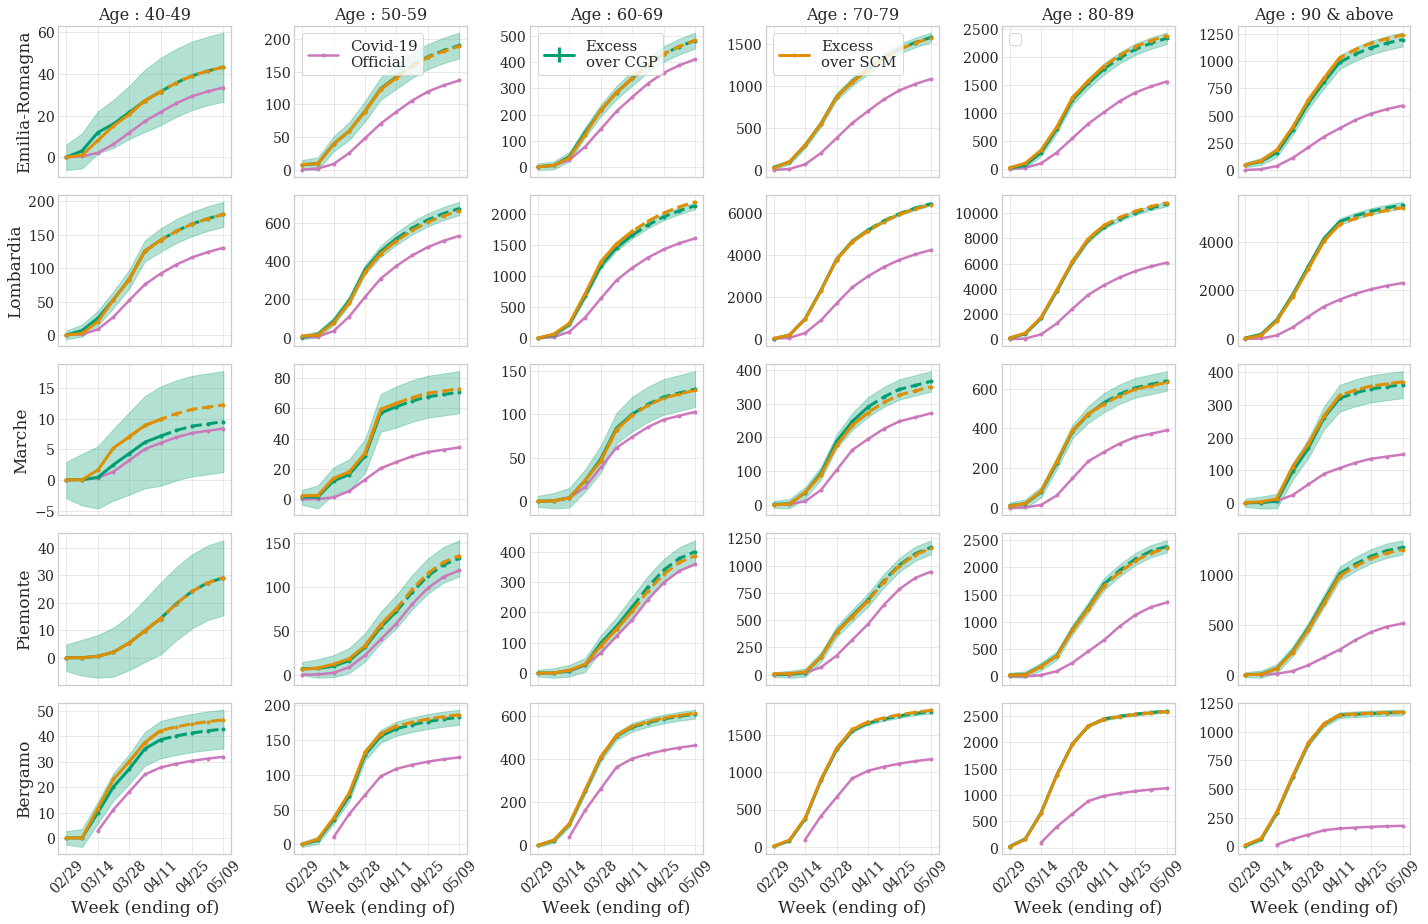

In [40]:
###  plot cumulative residuals for diferent age groups


# Td = 5 #number of data points we have
# isplit = [6] + [6+i*7 for i in range(1, 6)]
# xlab = [i[-1] for i in np.split(dfcovid[dfcovid['region'] == 'Lombardia']['date'].values, isplit)]
# xlab = [i.split('-')[1]+'/'+i.split('-')[2].split('T')[0] for i in xlab]
# xlab[-1] = '04/11'

fig, ax = plt.subplots(5, 6, figsize=(20, 13), sharex=True)
axf = ax.T.flatten()
plt.subplots_adjust(hspace=0.01, wspace=0.015)
axn = 0 

for age in range(4, 10):
    
    for ir, region in enumerate(['Emilia-Romagna', 'Lombardia', 'Marche', 'Piemonte', 'Bergamo']):
        
        scale = deathscaling2[region]
        key = region + '%d'%age
        xplot = np.arange(aextrapcovid[key].size)

        lbl = None 
        if axn == 5: lbl = "Covid-19\nOfficial"
        yy = np.cumsum(aextrapcovid[key])
        if region == 'Bergamo': axf[axn].plot(xplot[2:], yy[2:], marker='.', lw=2.5, color='C4', label=lbl)
        else: axf[axn].plot(xplot, yy, marker='.', lw=2.5, color='C4', label=lbl)
#         axf[axn].plot(xplot, yy, marker='.', lw=3, color='r', label=lbl)

        #
        
        lbl = None 
        if axn == 10: lbl = "Excess\nover CGP"
        yy = np.cumsum(aextrapcgpmean[key])
        yyerr = np.cumsum(aextrapcgpmeaner[key]**2)**0.5 *0
        axf[axn].errorbar(xplot[:Td2], yy[:Td2], yyerr[:Td2], 
                          color='C2', ls = "-", marker='.', lw=3, label=lbl)
        axf[axn].errorbar(xplot[Td2-1:], yy[Td2-1:], yyerr[Td2-1:], 
                          color='C2', ls = "--", marker='.', lw=3)
        yyerr = np.cumsum(aextrapcgpmeaner[key]**2)**0.5
        #
#         if (region == 'Piemonte') & (age == 4): yyerr = np.cumsum(aextrapcgpmeaner[key]**1)*1
        #
        axf[axn].fill_between(xplot, yy-yyerr, yy+yyerr,
                          color='C2', alpha=0.3)
        
        lbl = None 
        if axn == 15: lbl = "Excess\nover SCM"
        yy = np.cumsum(aextrapscmmean[key])
        axf[axn].errorbar(xplot[:Td2], yy[:Td2], 
                          color='C1', ls = "-", marker='.', lw=3, label=lbl)
        axf[axn].errorbar(xplot[Td-1:], yy[Td-1:], 
                          color='C1', ls = "--", marker='.', lw=3)
        #

#         lbl = None 
#         if axn == 20: lbl = "Excess\nover PCA2"
#         yy = np.cumsum(aextrappcfits[key])
#         yyerr = np.cumsum(aextrappcfitser[key]**2)**0.5 *0
#         axf[axn].errorbar(xplot[:Td], yy[:Td], yyerr[:Td], 
#                           color='C7', ls = "-", marker='.', lw=3, label=lbl)
#         axf[axn].errorbar(xplot[Td-1:], yy[Td-1:], yyerr[Td-1:], 
#                           color='C7', ls = "--", marker='.', lw=3)
#         yyerr = np.cumsum(aextrapcgpmeaner[key]**2)**0.5
#         axf[axn].fill_between(xplot, yy-yyerr, yy+yyerr,
#                           color='C7', alpha=0.3)
        


        if ir == 0: axf[axn].set_title('Age : ' + agegroups[age], fontsize=16)
#         if axn == 10: axf[axn].legend(fontsize=15, ncol=3, 
#                                       loc='upper center', bbox_to_anchor=(1.075, 1.415), frameon=False)
        if axn in [5, 10, 15, 20]: axf[axn].legend(fontsize=15, ncol=1, loc=2)
        if age == 4: axf[axn].set_ylabel(region, fontsize=17)
        axf[axn].grid(which = 'both', lw=0.5, alpha=0.8)
        axf[axn].tick_params('both', direction='in')        
        axn +=1
    

for axis in ax[-1,:]:
    axis.set_xticks(xplot[::2])
    axis.set_xticklabels(xlab[::2])
    axis.set_xlabel('Week (ending of)', fontsize=17)
# for axis in ax[:,0]:
#     axis.set_ylabel('Total mortality count', fontsize=17)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
#     plt.axhline(0, color='k', lw=0.5)
    
plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle('Residual between predicted and actual weekly mortality for different age groups', fontsize=20)
# plt.savefig('../paper_figs/residuals_cumulative_age.pdf')
# plt.savefig('../paper_figs/residuals_cumulative_age.jpeg')
plt.show()

# Calibrate against Diamond Princess Data

In [41]:
def poisson_interval(k, alpha=0.05): 
    
    
    """
    uses chisquared info to get the poisson interval. Uses scipy.stats 
    (imports in function). 
    """
    from scipy.stats import chi2
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return low, high

poisson_interval(11)

(5.49116036723684, 19.682038513301954)

### DP data from Wiki

In [42]:
# Data scraped manully

dpages = np.array([16,23,347,428,334,398,923,1015,216])
dpsym = np.array([0, 2,25,27,19,28,76,95,29])
dpasym = np.array([1,3,3,7,8,31,101,139,25])
dpinfect = dpsym + dpasym
dpdeath = np.array([0,0,0,0,0,0,1,7,4])

dpages[-2]/dpages.sum(), dpages[-1]/dpages.sum()

(0.2743243243243243, 0.05837837837837838)

We have to weight in the proportion of the population in 70-79, 80-89 in DP <br>
So ratio is - 1015/(1015 + 216 + 11), (/(1015 + 216) i.e 0.824, 0176



In [43]:
w1, w2 = dpages[-2:]/dpages[-2:].sum()
print(w1, w2)
dpifr = (dpdeath[-2:].sum()/dpinfect[-2:].sum()) * 100
dpifr = 11/330 * 100
deldpifr0 = 5.49/330 * 100
deldpifr1 = 19.68/330 * 100

0.8245329000812348 0.17546709991876522


## Get IFR when normalized to DP and Table 1 of paper

In [44]:
table = []
ifrtotdp = {}
ifrtotdperr = {}
ifrcgpdp = {}
ifrcgpdperr = {}
frdp = {}
frdperr = {}

for region in np.append(regions, 'Bergamo'):

    fpos =  fpositive_ex[region][0] * 100 
    ifr0 =  '%0.2f'%(ifrtot_ex[region][0]) 
    cvdeath = extrapcovid[region].sum()
    scale = deathscaling2[region]

    pfr = ifrcgp_ex[region]  * fpos
    pfrw = pfr[-3]*w1 + pfr[-2]*w2
    fr = pfrw / dpifr
    fr0, fr1 = fr-(pfrw/dpifr**2)*(dpifr-deldpifr0), fr+(pfrw/dpifr**2)*(deldpifr1-dpifr)
    frdp[region] = fr
    frdperr[region] = [fr0, fr1]
    
    ifr2 = ifrtot_ex[region][0] * fpos /fr
    ifrtotdp[region] = ifr2
    d1, d2 = (fr-fr0), (fr1-fr)
    if0, if1 = ifrtotdp[region]-  ifrtot_ex[region][0] * fpos /fr**2 *d1, ifrtotdp[region] + ifrtot_ex[region][0] * fpos /fr**2 *d2
    ifrtotdperr[region] = [if0, if1]

    ifrcgpdp[region] = ifrcgp_ex[region] * fpos /fr
    d1, d2 = (fr-fr0), (fr1-fr)
#     if0, if1 = ifrcgpdp[region]-  ifrcgp_ex[region] * fpos /fr**2 *d1, ifrcgpdp[region] + ifrcgp_ex[region] * fpos /fr**2 *d2
#     if0 = ifrcgpdp[region] -  ifrcgp_ex[region] * fpos /fr**2 *d1 #- ifrcgper_ex[region]
#     if1 = ifrcgpdp[region] + ifrcgp_ex[region] * fpos /fr**2 *d2 #+ ifrcgper_ex[region]
    if0 = ifrcgpdp[region] -  ((ifrcgp_ex[region] * fpos /fr**2 *d1)**2 + 4*ifrcgper_ex[region]**2)**0.5
    if0[if0<0] = 1e-5
    if1 = ifrcgpdp[region] + ((ifrcgp_ex[region] * fpos /fr**2 *d2)**2 + 4*ifrcgper_ex[region]**2)**0.5
    ifrcgpdperr[region] = [if0, if1]



for region in mainregions:

    fpos =  fpositive_ex[region][0] * 100 
    ifr0 =  '%0.2f'%(ifrtot_ex[region][0]) 
    cvdeath = extrapcovid[region].sum()
    scale = deathscaling2[region]

    pfr = ifrcgp_ex[region]  * fpos
    pfrw = pfr[-3]*w1 + pfr[-2]*w2
    
    fr = frdp[region]
    fr0, fr1 = frdperr[region]

    ifr2 = ifrtotdp[region]
    if0, if1 = ifrtotdperr[region]

    pred = '%d replacepmhere %d'%(int(extrapcgpmean[region].sum()), int(((extrapcgpmeaner[region]**2).sum())**0.5))
#         pred = '%d $\pm$ %d'%(int(extrapcgpmean[region].sum()), int(((extrapcgpmeaner[region]**2).sum())**0.5))

    table.append([region,  '%0.2f'%(popdict[region]/1e6), "%d"%cvdeath , 
                  '%0.2f'%(1/scale), 
                  pred,
                  '%0.2f'%(fpos/100), ifr0, 
                  '%0.2f (%0.2f-%0.2f)'%(fr/100,fr0/100, fr1/100), '%0.2f(%0.2f, %0.2f)'%(ifr2, if0, if1)])
# pd.DataFrame.from_dict(tmp)


table = pd.DataFrame(table, columns=['Region', 'Population', 'COVID-19', 'Completeness', 'Total', 
                                     'IR0', 'IFR0', 
                                     'IR-DP', 'IFR-DP' ])

# print(pd.DataFrame.from_dict(table).to_latex(index=False, header=False, columns=table.columns[:-1]))
print(pd.DataFrame.from_dict(table).to_latex(index=False, header=True, columns=table.columns[:-1]))
table

\begin{tabular}{llllllll}
\toprule
                       Region & Population & COVID-19 & Completeness &                    Total &   IR0 &  IFR0 &             IR-DP \\
\midrule
               Emilia-Romagna &       4.41 &     3827 &         0.95 &   5662 replacepmhere 166 &  0.29 &  0.44 &  0.13 (0.06-0.23) \\
                      Liguria &       1.60 &     1276 &         0.92 &   2175 replacepmhere 113 &  0.35 &  0.39 &  0.10 (0.05-0.19) \\
                    Lombardia &       9.86 &    14924 &         0.97 &  25530 replacepmhere 286 &  0.40 &  0.65 &  0.26 (0.13-0.47) \\
                       Marche &       1.57 &      958 &         0.83 &    1481 replacepmhere 97 &  0.43 &  0.22 &  0.09 (0.04-0.16) \\
                     Piemonte &       4.43 &     3331 &         0.93 &   5237 replacepmhere 204 &  0.36 &  0.33 &  0.10 (0.05-0.18) \\
                      Toscana &       3.73 &      937 &         0.89 &   1372 replacepmhere 158 &  0.18 &  0.21 &  0.03 (0.02-0.06) \\
 Trentino-A

Region Population COVID-19 Completeness  \
0                Emilia-Romagna       4.41     3827         0.95   
1                       Liguria       1.60     1276         0.92   
2                     Lombardia       9.86    14924         0.97   
3                        Marche       1.57      958         0.83   
4                      Piemonte       4.43     3331         0.93   
5                       Toscana       3.73      937         0.89   
6  Trentino-Alto Adige/Südtirol       1.05      438         0.92   
7                        Veneto       4.93     1643         0.87   
8                       Bergamo       1.09     3101         0.98   

                     Total   IR0  IFR0             IR-DP            IFR-DP  
0   5662 replacepmhere 166  0.29  0.44  0.13 (0.06-0.23)  0.99(0.49, 1.77)  
1   2175 replacepmhere 113  0.35  0.39  0.10 (0.05-0.19)  1.31(0.65, 2.34)  
2  25530 replacepmhere 286  0.40  0.65  0.26 (0.13-0.47)  0.99(0.49, 1.77)  
3    1481 replacepmhere 97  0.43  0.22  0.09 (0.04-0.16)  1.08(0.54, 1.93)  
4   5237 replacepmhere 204  0.36  0.33  0.10 (0.05-0.18)  1.18(0.59, 2.11)  
5   1372 replacepmhere 158  0.18  0.21  0.03 (0.02-0.06)  1.13(0.56, 2.02)  
6    1107 replacepmhere 74  0.38  0.28  0.11 (0.05-0.19)  0.99(0.50, 1.78)  
7   2440 replacepmhere 164  0.09  0.54  0.05 (0.02-0.09)  1.04(0.52, 1.85)  
8    6285 replacepmhere 39  1.00  0.58  0.69 (0.35-1.24)  0.83(0.42, 1.49)

In [45]:
table.style.set_properties(**{'text-align': 'right'})
table[['Region', 'IR0', 'IFR0', "IR-DP", "IFR-DP"]].style.set_properties(**{'text-align': 'right'})


## Fig. 5 - Plot realistic IFR with DP estimates 

In [46]:
verity = np.array([0.0016, 0.007, 0.031, 0.084, 0.16, 0.6, 1.9, 4.3, 7.8])
verityer0 = np.array([0.000185, 0.0015, 0.014, 0.041, 0.076, 0.34, 1.1, 2.5, 3.8, ])
verityer1 = np.array([0.0249, 0.05, 0.092, 0.185, 0.32, 1.3, 3.9, 8.4, 13.3])

In [47]:
#Change order of plotting to highlight Lombarida
mainregionsb2 = np.array(mainregions).copy()[::-1]
mainregionsb2 = [rr for rr in mainregionsb2 if rr != 'Lombardia']
mainregionsb2.append('Lombardia')
#np.concatenate([mainregionsb2[2:][::-1], mainregionsb2[[0, 1]] ])
# mainregionsb2 = [i for i in mainregionsb2 if i != 'Puglia']


##Get error estimates of the IFR
vals =  np.array([ifrcgp_ex[region] for region in mainregions[:-1]])
valserr =  np.array([ifrcgper_ex[region] for region in mainregions[:-1]])
wts = valserr**-2
wts[vals<1e-4] = 0
ifrcgpmean = (vals*wts).sum(axis=0) / wts.sum(axis=0)
ifrcgpstd =  ((wts * (vals-ifrcgpmean)**2).sum(axis=0)/wts.sum(axis=0))**0.5 *1
# ifrcgpstd =  (1/wts.sum(axis=0))**0.5

vals =  np.array([ifrtot_ex[region][0] for region in mainregions[:-1]])
valserr =  np.array([ifrtot_ex[region][1] for region in mainregions[:-1]])
wts = valserr**-2
wts[vals<1e-4] = 0
ifrcgptotmean = (vals*wts).sum(axis=0) / wts.sum(axis=0)
# ifrcgptotstd =  (1/wts.sum(axis=0))**0.5 *1
ifrcgptotstd =  ((wts * (vals-ifrcgptotmean)**2).sum()/wts.sum(axis=0))**0.5 *1


vals =  np.array([ifrcgpdp[region] for region in mainregions[:-1]  if frdp[region] > 10] )
valserr =  np.array([ifrcgpdperr[region] for region in mainregions[:-1]  if frdp[region] > 10])
# vals =  np.array([ifrcgpdp[region] for region in mainregions[:-1]])
# valserr =  np.array([ifrcgpdperr[region] for region in mainregions[:-1]])
wts = (valserr[:, 1, :] -valserr[:, 0, :])/2.
# wts = ((valserr**2).sum(axis=1)**0.5)**-2.
wts[vals<1e-4] = 0
ifrcgpmeandp = (vals*wts).sum(axis=0) / wts.sum(axis=0)
ifrcgpstddp =  ((wts * (vals-ifrcgpmean)**2).sum(axis=0)/wts.sum(axis=0))**0.5 *1


xx = np.arange(len(agegroups))

##
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

ir = 0
for _, region in enumerate(mainregionsb2[:] ):
    if frdp[region] > 10:
        fpos = fpositive_ex[region][-1]
        lbl1, lbl2, lbl3 = None, None, None
        if ir <= 5: lbl1 = region 
        if ir > 5: lbl2 = region 
        msize, fmt, cc, al  = 4, 'o', 'C%d'%ir, 0.8
#         if region == "Bergamo" : lbl3 = 'Bergamo'
#         if region == 'Veneto' : cc = 'y'
        if region == 'Lombardia': msize, fmt, cc, al = 5, 'v', 'k', 0.8
        if region == 'Bergamo': msize, fmt, cc, al = 5, '^', 'k', 0.8
        if region == 'Trentino-Alto Adige/Südtirol': lbl1 = 'Trentino'
        print(ir, region)
        xx2 = xx + ir*0.06-0.211
        xxv = xx[:-1]*1.0
        xxv[-1] += 0.5
        yy, yyerr = np.array(ifrcgp_ex[region])*fpos, np.array(ifrcgper_ex[region])*fpos
        yy[yy<0] = np.NaN
        ax[0].errorbar(xx2, yy, yyerr,
                     label=lbl1, fmt=fmt, color=cc, markersize=msize, alpha=al)

        yy, yyerr = ifrcgp_ex[region].copy(), ifrcgper_ex[region].copy()
        yy[yy<0] = np.NaN
        if region != 'Bergamo': ax[1].errorbar(xx2, yy, yyerr, 
                       fmt=fmt, color=cc, label=lbl2, markersize=msize, alpha=al)


        yy, yyerr = ifrcgpdp[region].copy(), np.array(ifrcgpdperr[region].copy())
        yy[yy<0] = np.NaN
        yyerr = [yy - yyerr[0], yyerr[1] - yy]
        ax[2].errorbar(xx2, yy, yyerr,
                     fmt=fmt, color=cc, markersize=msize, alpha=al-0.1, label=lbl3)

        ax[1].axhline(ifrtot_ex[region][0], color=cc, lw=0.5)
        ax[2].axhline(ifrtotdp[region], color=cc, lw=0.5)
        ir += 1
    
ax[2].errorbar(xxv, verity, [verityer0, verityer1], 
                   fmt='*', color='magenta', label='Verity et.al.', markersize=6, alpha=0.7)
cc = 'gray'
ax[1].errorbar(xx, ifrcgpmean,  lw=2, color=cc, alpha=0.8, label='Weighted Mean')
ax[1].fill_between(xx, ifrcgpmean-ifrcgpstd, ifrcgpmean+ifrcgpstd, color=cc, alpha=0.2)

ax[2].errorbar(xx, ifrcgpmeandp, lw=2, color=cc, alpha=0.8)
ax[2].fill_between(xx, ifrcgpmeandp-ifrcgpstddp, ifrcgpmeandp+ifrcgpstddp, color=cc, alpha=0.2)

ax[2].plot(xx[-3:], xx[-3:]*0 + dpifr, label="DP IFR", alpha=1.0, color='C9')
ax[2].fill_between(xx[-3:], deldpifr0, deldpifr1, alpha=0.2, color='C9')
    

for axis in ax:
    axis.legend(fontsize=14, ncol=1, loc=0)
    axis.grid(which = 'both',  alpha=0.8, lw=0.5)
    axis.set_xticks(xx)
    axis.set_xticklabels(agegroups[:])
    axis.set_xlabel('Age Group', fontsize=14)
    axis.set_ylim(2*1e-3, 50)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=13)
    plt.yticks(fontsize=13)
    plt.yscale('log')
    
ax[0].set_ylabel('PFR (in %)', fontsize=14)
ax[1].set_ylabel(r'IFR (lower limit, IR=TPR$_{\rm max}$) (in %)', fontsize=14)
ax[2].set_ylabel('IFR (matched to DP data) (in %)', fontsize=14)

plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle('Infection Fatality Rate (in %) from cumulative statistics)', fontsize=15)
# plt.savefig('../paper_figs/ifr.pdf')
# plt.savefig('../paper_figs/ifr.jpeg', dpi=300)

plt.show()


0 Bergamo
1 Trentino-Alto Adige/Südtirol
2 Piemonte
3 Liguria
4 Emilia-Romagna
5 Lombardia


# Table 2 for the paper with age distribution

In [48]:
ymr = {}
ymr['Lombardia'] = [0, 0, 0, 0, 0.11, 0.28, 0.75, 2.1, 6.6, 18.8]
ymr['Bergamo'] = [0, 0, 0, 0, 0.11, 0.26, 0.76, 2.1, 6.6, 19.3]
ymr['Emilia-Romagna'] = [0, 0, 0, 0, 0.11, 0.29, 0.75, 1.99, 6.6, 19.1]

In [49]:
Ages =  ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', ' geq 90 ']

table = []
for rr in ['Lombardia', 'Bergamo', 'Emilia-Romagna']:
    table.append([rr, "", "", "", "", "", ""])
    tots, totscovid = 0, 0 
    for age in range(0, 10):
        key = rr+'%d'%age
        dd, dderr = int(aextrapcgpmean[key].sum()), int((aextrapcgpmeaner[key]**2).sum()**0.5)
        dd2, dderr = int(aextrapcovid[key].sum()), int((aextrapcgpmeaner[key]**2).sum()**0.5)
        tots += dd
        totscovid += dd2
        
    for age in range(3, 10):
        tmp = ['']
        tmp.append(Ages[age])
        key = rr+'%d'%age
        tmp.append('%0.3f'%(agedict[rr][age]/popdict[rr]))
        tmp.append('%0.2f'%(ymr[rr][age]))
        tmp.append('%0.2f'%(aextrapcovid[key].sum()/totscovid))
        dd, dderr = int(aextrapcgpmean[key].sum()), int((aextrapcgpmeaner[key]**2).sum()**0.5)
#         tmp.append('%0.3f replacepmhere %0.3f'%(dd/tots, dderr/tots))
        tmp.append('%0.3f'%(dd/tots))
#         tmp.append('%0.3f $\pm$ %0.3f'%(dd/tots, dderr/tots))
        dd, dderr = ifrcgp_ex[rr][age], ifrcgper_ex[rr][age]
        tmp.append('%0.2f '%(dd))
#         tmp.append('%0.2f replacepmhere %0.2f'%(dd, dderr))
#         tmp.append('%0.2f $\pm$ %0.2f'%(dd, dderr))
        tmp.append('%0.2f (%0.2f-%0.2f)'%(ifrcgpdp[rr][age], ifrcgpdperr[rr][0][age], ifrcgpdperr[rr][1][age]))
        table.append(tmp)
table = pd.DataFrame(table, columns = ['', 'Age groups', 'Population Fraction', 'YMR', 'Covid Fraction', 'Excess Fraction', 'IFR (lower)', 'IFR (DP)'])
print(table.to_latex(index=False, header=False))

table

\begin{tabular}{llllllll}
\toprule
      Lombardia &           &        &        &       &        &         &                None \\
                &     30-39 &  0.120 &   0.00 &  0.00 &  0.001 &   0.01  &    0.01 (0.00-0.02) \\
                &     40-49 &  0.161 &   0.11 &  0.01 &  0.007 &   0.03  &    0.04 (0.02-0.08) \\
                &     50-59 &  0.159 &   0.28 &  0.04 &  0.026 &   0.11  &    0.17 (0.08-0.30) \\
                &     60-69 &  0.120 &   0.75 &  0.11 &  0.083 &   0.46  &    0.70 (0.35-1.26) \\
                &     70-79 &  0.101 &   2.10 &  0.28 &  0.250 &   1.65  &    2.53 (1.26-4.52) \\
                &     80-89 &  0.060 &   6.60 &  0.41 &  0.417 &   4.65  &   7.12 (3.55-12.74) \\
                &   geq 90  &  0.012 &  18.80 &  0.15 &  0.215 &  11.42  &  17.50 (8.72-31.33) \\
        Bergamo &           &        &        &       &        &         &                None \\
                &     30-39 &  0.120 &   0.00 &  0.00 &  0.001 &   0.00  &    0.01 

Age groups Population Fraction    YMR Covid Fraction  \
0        Lombardia                                                        
1                       30-39               0.120   0.00           0.00   
2                       40-49               0.161   0.11           0.01   
3                       50-59               0.159   0.28           0.04   
4                       60-69               0.120   0.75           0.11   
5                       70-79               0.101   2.10           0.28   
6                       80-89               0.060   6.60           0.41   
7                     geq 90                0.012  18.80           0.15   
8          Bergamo                                                        
9                       30-39               0.120   0.00           0.00   
10                      40-49               0.161   0.11           0.01   
11                      50-59               0.161   0.26           0.04   
12                      60-69               0.121   0.76           0.15   
13                      70-79               0.094   2.10           0.38   
14                      80-89               0.052   6.60           0.36   
15                    geq 90                0.010  19.30           0.06   
16  Emilia-Romagna                                                        
17                      30-39               0.116   0.00           0.00   
18                      40-49               0.161   0.11           0.01   
19                      50-59               0.157   0.29           0.04   
20                      60-69               0.121   0.75           0.11   
21                      70-79               0.103   1.99           0.28   
22                      80-89               0.066   6.60           0.41   
23                    geq 90                0.016  19.10           0.15   

   Excess Fraction IFR (lower)            IFR (DP)  
0                                             None  
1            0.001       0.01     0.01 (0.00-0.02)  
2            0.007       0.03     0.04 (0.02-0.08)  
3            0.026       0.11     0.17 (0.08-0.30)  
4            0.083       0.46     0.70 (0.35-1.26)  
5            0.250       1.65     2.53 (1.26-4.52)  
6            0.417       4.65    7.12 (3.55-12.74)  
7            0.215      11.42   17.50 (8.72-31.33)  
8                                             None  
9            0.001       0.00     0.01 (0.00-0.01)  
10           0.007       0.03     0.04 (0.02-0.07)  
11           0.029       0.11     0.15 (0.08-0.28)  
12           0.095       0.47     0.68 (0.34-1.22)  
13           0.283       1.81     2.61 (1.30-4.66)  
14           0.404       4.67    6.75 (3.37-12.07)  
15           0.182      10.60   15.31 (7.63-27.40)  
16                                            None  
17           0.003       0.01     0.03 (0.01-0.06)  
18           0.007       0.02     0.05 (0.02-0.09)  
19           0.032       0.10     0.21 (0.11-0.38)  
20           0.083       0.31     0.70 (0.35-1.26)  
21           0.270       1.20     2.71 (1.35-4.85)  
22           0.398       2.78    6.27 (3.12-11.22)  
23           0.205       5.90   13.33 (6.62-23.86)

In [50]:
for rr in ['Lombardia', 'Bergamo', 'Emilia-Romagna']:
    tmp = [rr]
    tmp.append('%0.2f '%(extrapcgpmean[rr].sum()/popdict[rr]*100))
    tmp.append('%0.2f (%0.2f-%0.2f)'%(ifrtotdp[rr], ifrtotdperr[rr][0], ifrtotdperr[rr][1]))
    print(tmp)

['Lombardia', '0.26 ', '0.99 (0.49-1.77)']
['Bergamo', '0.58 ', '0.83 (0.42-1.49)']
['Emilia-Romagna', '0.13 ', '0.99 (0.49-1.77)']


In [51]:
#Total deaths

dd, dderr = 0, 0
for rr in dfmort['region'].unique():
    try: 
        dd += extrapcgpmean[rr].sum()
        dderr += (extrapcgpmeaner[rr]**2).sum()
    except Exception as e: print(e)
print(dd, dderr**0.5)

#Total deaths

dd, dderr = 0, 0
for rr in dfmort['region'].unique():
    try: 
        dd += extrapcgpmeanflat[rr].sum()
        dderr += (extrapcgpmeanflater[rr]**2).sum()
    except Exception as e: print(e)
print(dd, dderr**0.5)

48859.30951315059 695.7910819945478
53244.17202669948 698.9349700055737


In [52]:
for rr in ['Bergamo', 'Lombardia']:
    print(rr)
    tot = 0 
    fage = []
    for age in range(10):
        tot += aextrapcgpmean[rr+'%d'%age].sum()
        fage.append(aextrapcgpmean[rr+'%d'%age].sum())
    print("Ages : ", agegroups)
    print("fraction of deaths in that age group to total deaths")
    print(['%0.2f'%(i*100) for i in np.array(fage)/tot])
    print("# deaths / population in age group")
    print(['%0.2f'%(i*100) for i in (np.array(fage)/(agedict[rr]*popdict[rr]/agedict[rr].sum()))])



Bergamo
Ages :  ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90 & above']
fraction of deaths in that age group to total deaths
['0.01', '0.05', '0.02', '0.07', '0.67', '2.86', '9.47', '28.25', '40.38', '18.23']
# deaths / population in age group
['0.00', '0.00', '0.00', '0.00', '0.03', '0.11', '0.47', '1.81', '4.67', '10.60']
Lombardia
Ages :  ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90 & above']
fraction of deaths in that age group to total deaths
['0.01', '0.02', '0.02', '0.15', '0.70', '2.63', '8.28', '25.03', '41.70', '21.46']
# deaths / population in age group
['0.00', '0.00', '0.00', '0.00', '0.01', '0.04', '0.18', '0.66', '1.86', '4.57']
